In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFont, ImageDraw
from scipy.stats import norm
import numpy as np
import random
from string import ascii_letters, digits

In [63]:
# ---------------------------
# 1. Hyperparameters
# ---------------------------
batch_size = 64
image_size = 64
num_epochs = 5
learning_rate_D = 5e-4
learning_rate_G = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [64]:
# ---------------------------
# 2. Custom Dataset Loader (For ./data/train/*.png)
# ---------------------------
class CaptchaDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert('1')  # Ensure binary format
        if self.transform:
            image = self.transform(image)
        return image

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Resize((80, 800)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1,1]
])

# Create dataset and dataloader
dataset = CaptchaDataset(image_folder="./data/preprocessed_images", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

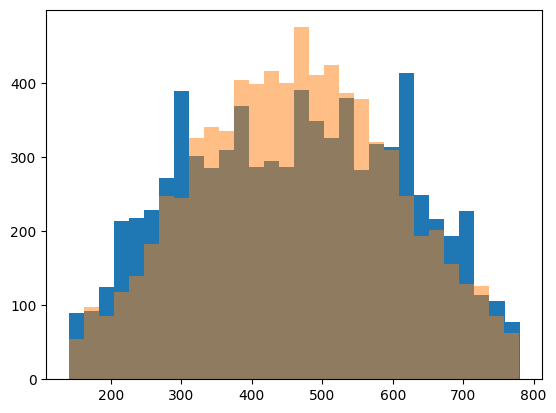

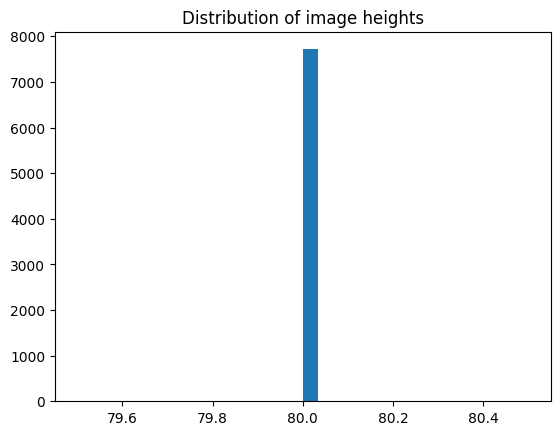

In [65]:
dataset_explore = CaptchaDataset(image_folder="./data/preprocessed_images", transform=None)
# plot image dimensions distribution in the dataset
widths = list(map(lambda image: image.size[0], dataset_explore))
plt.hist(widths, bins=30)

# fit a normal distribution to the data
min_width = min(widths)
max_width = max(widths)
mu, std = norm.fit(widths)

# sample and compare
sampled_widths = norm.rvs(mu, std, 8000)
sampled_widths = sampled_widths[(sampled_widths >= min_width) & (sampled_widths <= max_width)]
plt.hist(sampled_widths, bins=30, alpha=0.5)
plt.show()


heights = list(map(lambda image: image.size[1], dataset_explore))
plt.hist(heights, bins=30)
plt.title("Distribution of image heights")
plt.show()

### Captcha generation pipeline
Use PIL to generate a captcha image of size (w, 80)
where w is sampled using normal distribution params obtained above

For each image, randomly choose these params:
1. width: image width sampled from distribution above
1. font: text font in a captcha, random chosen in a pre-defined subset.
    - TODO: generate captcha that contains more than 1 font
1. font_size: font size of each letter
1. gap: (expected) spearation between each 2 letters
1. center_height: (expected) central height of letters

For each character in the image, randomly choose these params:
1. char: the character itself, in alphanumeric
1. x_displacement: small horizontal displacement
1. y_displacement: small vertical displacement
1. rotation: anticlockwise rotation in degrees

Use these params to draw letters in binary format until right margin

In [66]:
# Known values
MU = mu
STD = std
MIN_WIDTH = min_width
MAX_WIDTH = max_width
print(f"mu: {MU}, std: {STD}, min_width: {MIN_WIDTH}, max_width: {MAX_WIDTH}")

LEFT_MARGIN = 30 # if x position is below this value, regenerate

HEIGHT = 80
FONT_FILENAMES = [f for f in os.listdir("./GAN/fonts") if f.endswith('.ttf')]
FONTSIZE_MIN = 28
FONTSIZE_MAX = 40
GAP_MIN = 5 # should not be too high, need some overlap
GAP_MAX = 30

TRANSLATION_PROBABILITY = 0.5
X_DISPLACEMENT_MIN = -5
X_DISPLACEMENT_MAX = 5
Y_DISPLACEMENT_MIN = -5
Y_DISPLACEMENT_MAX = 5
ROTATION_PROBABILITY = 0.5
ROTATION_MIN = -30
ROTATION_MAX = 30

ALPHANUMERIC = ascii_letters + digits

mu: 459.9397278029812, std: 154.63231617159508, min_width: 140, max_width: 780


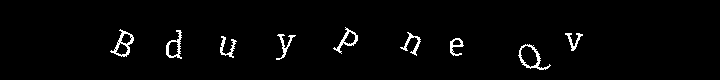

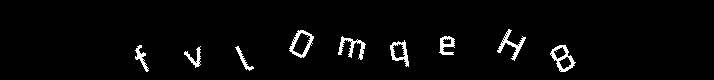

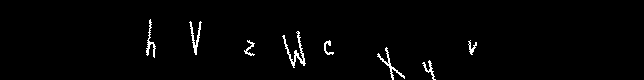

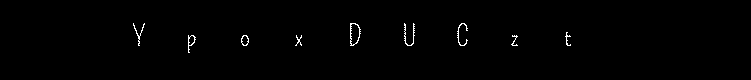

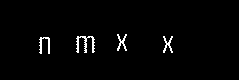

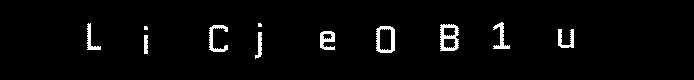

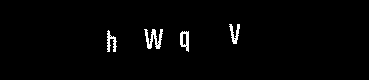

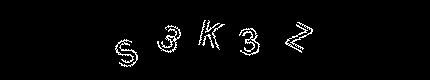

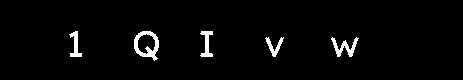

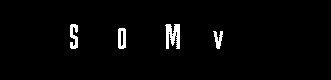

In [67]:
def get_random_width(mu, std, min_width, max_width):
    w = int(norm.rvs(mu, std))
    if w >= min_width and w <= max_width:
        return w
    return get_random_width(mu, std, min_width, max_width)


def generate_random_captcha():
    width = get_random_width(MU, STD, MIN_WIDTH, MAX_WIDTH)
    height = HEIGHT
    font_size = random.randint(FONTSIZE_MIN, FONTSIZE_MAX)
    font = ImageFont.truetype("./GAN/fonts/" + random.choice(FONT_FILENAMES), font_size)
    gap = random.randint(GAP_MIN, GAP_MAX)
    center_height = random.randint(HEIGHT // 20 * 9, HEIGHT // 20 * 11)
    has_translation = random.random() < TRANSLATION_PROBABILITY
    has_rotation = random.random() < ROTATION_PROBABILITY

    # Approximation for the number of characters
    # TODO: check distribution of num characters generated and change this if needed
    num_chars = max(min((width - LEFT_MARGIN * 2) // 70, 9), 4)

    img = Image.new('1', (width, height))

    for i in range(num_chars):
        # Draw a character (pun intended)
        char = random.choice(ALPHANUMERIC)

        expected_x_disp_in_characters_from_center = i - num_chars / 2
        expected_x_start = width / 2 + (font_size + gap) * expected_x_disp_in_characters_from_center

        # TODO: check distribution, change random function if needed
        x_displacement = 0
        y_displacement = 0
        rotation = 0
        if has_translation:
          x_displacement = random.randint(X_DISPLACEMENT_MIN, X_DISPLACEMENT_MAX)
          y_displacement = random.randint(Y_DISPLACEMENT_MIN, Y_DISPLACEMENT_MAX)
        if has_rotation:
          rotation = random.randint(ROTATION_MIN, ROTATION_MAX)

        x_start = int(expected_x_start + x_displacement)
        char_height = font.getmetrics()[0] + font.getmetrics()[1] # ascent + descent
        y_start = int(center_height - char_height / 2 + y_displacement)

        # regenerate if out of bounds
        if x_start < LEFT_MARGIN:
            return generate_random_captcha()
        elif y_start + char_height > height or y_start < 0:
            return generate_random_captcha()

        text_img = Image.new('L', (char_height, char_height))
        text_draw = ImageDraw.Draw(text_img)
        text_draw.text((0, 0), char, font=font, fill=255, spacing=0)
        text_img = text_img.rotate(rotation, expand=True)
        img.paste(text_img, (x_start, y_start), text_img)

    # print(font.getname())
    return img

for i in range(10):
    img = generate_random_captcha()
    display(img)

In [68]:
def display_image(img_tensor):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    display(Image.fromarray(img_array[0], 'L'))

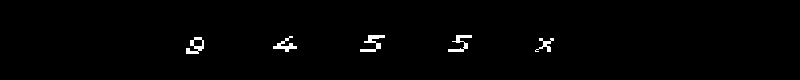

In [9]:
display_image(dataset[11])

In [69]:
class Generator(nn.Module):
    def __init__(self, img_channels=1, feature_g=64, num_res_blocks = 4):
        super(Generator, self).__init__()

        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, feature_g, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                # nn.BatchNorm2d(feature_g),
                nn.ReLU(inplace=True),
                nn.Conv2d(feature_g, feature_g, 3, 1, 1),
                # nn.BatchNorm2d(feature_g)
            )
         for _ in range(num_res_blocks)])

        self.final = nn.Sequential(
            nn.Conv2d(feature_g, img_channels, 1, 1, 0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        for b in self.residual_blocks:
            x = x + b(x)
        x = self.final(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, feature_d=128):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 80 * 800
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(feature_d),
            # 40 * 400
            nn.ReLU(),


            nn.Conv2d(feature_d, feature_d // 2, 4, 2, 1, bias=False),
            # 20 * 200
            # nn.BatchNorm2d(feature_d * 2),
            nn.MaxPool2d((2, 2), (2, 2)),
            # 10 * 80
            nn.ReLU(),

            nn.Conv2d(feature_d // 2, feature_d // 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(feature_d * 4),
            # 5 * 40
            nn.ReLU(),

            nn.Conv2d(feature_d // 4, 1, 5, 1, 0),
            # 1 * 36

            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
def self_regularisation_loss(fake, real, delta=1e-6):
    return delta * torch.sum(torch.abs(fake - real))

optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate_D, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate_G, betas=(0.5, 0.999))

clip_grad_norm_(netG.parameters(), 1)

tensor(0.)

In [70]:
import gc

gc.collect()

torch.cuda.empty_cache()

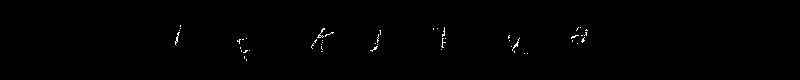

Epoch [0/5] Batch 0/121 Loss D: 1.3868, Loss G: 3.3044
Epoch [0/5] Batch 1/121 Loss D: 1.3377, Loss G: 2.6144
Epoch [0/5] Batch 2/121 Loss D: 1.3138, Loss G: 2.0712
Epoch [0/5] Batch 3/121 Loss D: 1.3392, Loss G: 1.7548
Epoch [0/5] Batch 4/121 Loss D: 1.2901, Loss G: 1.5043


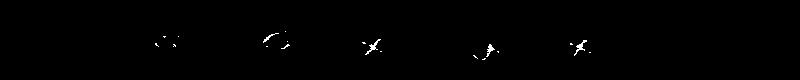

Epoch [0/5] Batch 5/121 Loss D: 1.2426, Loss G: 1.3115
Epoch [0/5] Batch 6/121 Loss D: 1.1548, Loss G: 1.1418
Epoch [0/5] Batch 7/121 Loss D: 1.0809, Loss G: 1.0014
Epoch [0/5] Batch 8/121 Loss D: 1.0800, Loss G: 0.8812
Epoch [0/5] Batch 9/121 Loss D: 1.1189, Loss G: 0.8158


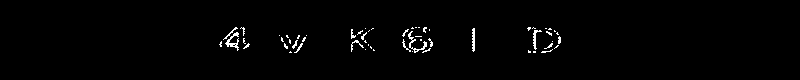

Epoch [0/5] Batch 10/121 Loss D: 1.0878, Loss G: 0.8194
Epoch [0/5] Batch 11/121 Loss D: 1.1736, Loss G: 0.8921
Epoch [0/5] Batch 12/121 Loss D: 1.1108, Loss G: 1.0209
Epoch [0/5] Batch 13/121 Loss D: 1.0887, Loss G: 1.0476
Epoch [0/5] Batch 14/121 Loss D: 1.0836, Loss G: 0.9927


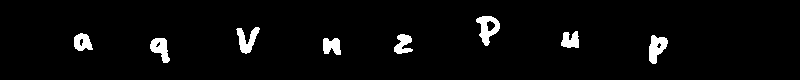

Epoch [0/5] Batch 15/121 Loss D: 1.1213, Loss G: 1.1486
Epoch [0/5] Batch 16/121 Loss D: 1.0976, Loss G: 1.2379
Epoch [0/5] Batch 17/121 Loss D: 1.2522, Loss G: 1.3254
Epoch [0/5] Batch 18/121 Loss D: 1.3432, Loss G: 0.8414
Epoch [0/5] Batch 19/121 Loss D: 1.1954, Loss G: 1.0736


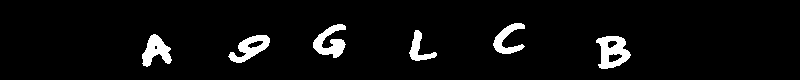

Epoch [0/5] Batch 20/121 Loss D: 1.3407, Loss G: 1.1924
Epoch [0/5] Batch 21/121 Loss D: 1.2852, Loss G: 0.9444
Epoch [0/5] Batch 22/121 Loss D: 1.1926, Loss G: 1.1301
Epoch [0/5] Batch 23/121 Loss D: 1.2215, Loss G: 1.0846
Epoch [0/5] Batch 24/121 Loss D: 1.2369, Loss G: 0.8677


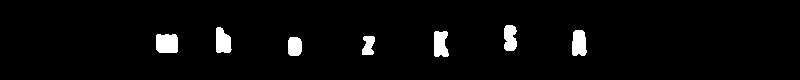

Epoch [0/5] Batch 25/121 Loss D: 1.2782, Loss G: 1.2334
Epoch [0/5] Batch 26/121 Loss D: 1.3021, Loss G: 1.0340
Epoch [0/5] Batch 27/121 Loss D: 1.1174, Loss G: 0.9607
Epoch [0/5] Batch 28/121 Loss D: 1.2005, Loss G: 0.9779
Epoch [0/5] Batch 29/121 Loss D: 1.2938, Loss G: 1.0662


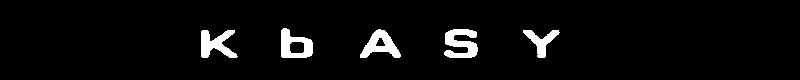

Epoch [0/5] Batch 30/121 Loss D: 1.2488, Loss G: 1.0011
Epoch [0/5] Batch 31/121 Loss D: 1.2068, Loss G: 0.9713
Epoch [0/5] Batch 32/121 Loss D: 1.1949, Loss G: 1.0357
Epoch [0/5] Batch 33/121 Loss D: 1.2181, Loss G: 1.0027
Epoch [0/5] Batch 34/121 Loss D: 1.1226, Loss G: 0.9853


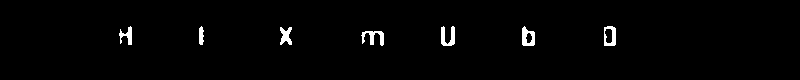

Epoch [0/5] Batch 35/121 Loss D: 1.1979, Loss G: 1.0684
Epoch [0/5] Batch 36/121 Loss D: 1.1894, Loss G: 1.0633
Epoch [0/5] Batch 37/121 Loss D: 1.2694, Loss G: 0.9632
Epoch [0/5] Batch 38/121 Loss D: 1.1474, Loss G: 1.1513
Epoch [0/5] Batch 39/121 Loss D: 1.1403, Loss G: 1.0936


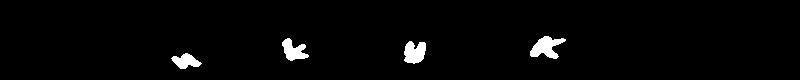

Epoch [0/5] Batch 40/121 Loss D: 1.2440, Loss G: 0.9516
Epoch [0/5] Batch 41/121 Loss D: 1.0867, Loss G: 1.1128
Epoch [0/5] Batch 42/121 Loss D: 1.1675, Loss G: 1.1533
Epoch [0/5] Batch 43/121 Loss D: 1.1817, Loss G: 0.8356
Epoch [0/5] Batch 44/121 Loss D: 1.1185, Loss G: 1.5157


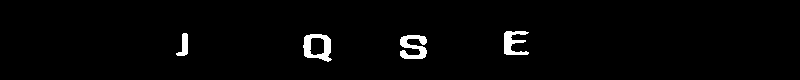

Epoch [0/5] Batch 45/121 Loss D: 1.2997, Loss G: 0.7851
Epoch [0/5] Batch 46/121 Loss D: 1.1833, Loss G: 1.0230
Epoch [0/5] Batch 47/121 Loss D: 1.1571, Loss G: 1.1479
Epoch [0/5] Batch 48/121 Loss D: 1.1151, Loss G: 0.9990
Epoch [0/5] Batch 49/121 Loss D: 1.2526, Loss G: 0.9383


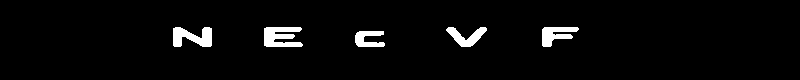

Epoch [0/5] Batch 50/121 Loss D: 1.1567, Loss G: 1.1783
Epoch [0/5] Batch 51/121 Loss D: 1.2246, Loss G: 1.1120
Epoch [0/5] Batch 52/121 Loss D: 1.1833, Loss G: 0.9349
Epoch [0/5] Batch 53/121 Loss D: 1.1092, Loss G: 0.9559
Epoch [0/5] Batch 54/121 Loss D: 1.1181, Loss G: 1.2411


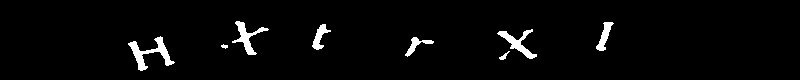

Epoch [0/5] Batch 55/121 Loss D: 1.2111, Loss G: 1.0038
Epoch [0/5] Batch 56/121 Loss D: 1.1490, Loss G: 0.9725
Epoch [0/5] Batch 57/121 Loss D: 1.1062, Loss G: 1.1401
Epoch [0/5] Batch 58/121 Loss D: 1.1223, Loss G: 1.0120
Epoch [0/5] Batch 59/121 Loss D: 1.0346, Loss G: 1.0198


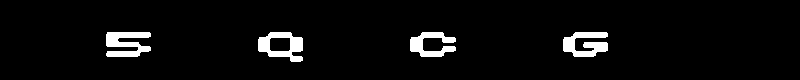

Epoch [0/5] Batch 60/121 Loss D: 1.1727, Loss G: 1.6277
Epoch [0/5] Batch 61/121 Loss D: 1.2162, Loss G: 0.7639
Epoch [0/5] Batch 62/121 Loss D: 1.2363, Loss G: 1.1566
Epoch [0/5] Batch 63/121 Loss D: 1.0056, Loss G: 1.2256
Epoch [0/5] Batch 64/121 Loss D: 1.1751, Loss G: 0.9688


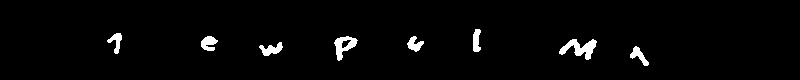

Epoch [0/5] Batch 65/121 Loss D: 1.0732, Loss G: 1.2026
Epoch [0/5] Batch 66/121 Loss D: 1.1254, Loss G: 1.1475
Epoch [0/5] Batch 67/121 Loss D: 1.1032, Loss G: 1.1249
Epoch [0/5] Batch 68/121 Loss D: 1.2538, Loss G: 1.0938
Epoch [0/5] Batch 69/121 Loss D: 1.0950, Loss G: 1.1700


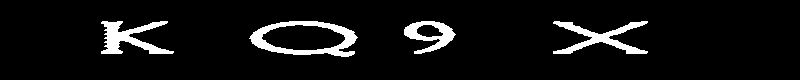

Epoch [0/5] Batch 70/121 Loss D: 1.1181, Loss G: 1.2852
Epoch [0/5] Batch 71/121 Loss D: 1.2100, Loss G: 0.9283
Epoch [0/5] Batch 72/121 Loss D: 1.2106, Loss G: 1.1929
Epoch [0/5] Batch 73/121 Loss D: 0.9867, Loss G: 1.2403
Epoch [0/5] Batch 74/121 Loss D: 1.1075, Loss G: 1.0659


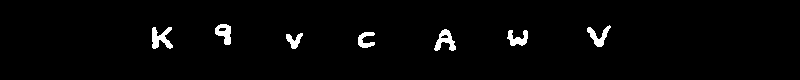

Epoch [0/5] Batch 75/121 Loss D: 1.3171, Loss G: 1.1733
Epoch [0/5] Batch 76/121 Loss D: 1.1925, Loss G: 1.0663
Epoch [0/5] Batch 77/121 Loss D: 1.2361, Loss G: 1.1066
Epoch [0/5] Batch 78/121 Loss D: 1.2283, Loss G: 1.0574
Epoch [0/5] Batch 79/121 Loss D: 1.0816, Loss G: 1.0554


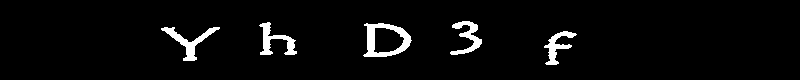

Epoch [0/5] Batch 80/121 Loss D: 1.0122, Loss G: 1.1708
Epoch [0/5] Batch 81/121 Loss D: 1.0678, Loss G: 1.1158
Epoch [0/5] Batch 82/121 Loss D: 1.1406, Loss G: 1.2107
Epoch [0/5] Batch 83/121 Loss D: 1.3225, Loss G: 1.2570
Epoch [0/5] Batch 84/121 Loss D: 1.3159, Loss G: 1.0856


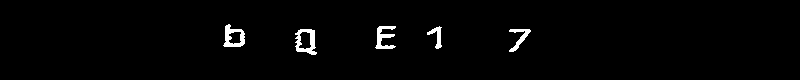

Epoch [0/5] Batch 85/121 Loss D: 1.0480, Loss G: 1.0801
Epoch [0/5] Batch 86/121 Loss D: 1.2512, Loss G: 1.1315
Epoch [0/5] Batch 87/121 Loss D: 1.2580, Loss G: 1.0607
Epoch [0/5] Batch 88/121 Loss D: 1.0772, Loss G: 0.9989
Epoch [0/5] Batch 89/121 Loss D: 1.2041, Loss G: 1.0830


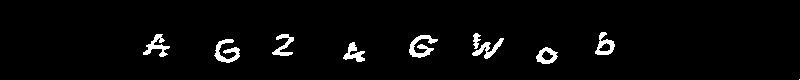

Epoch [0/5] Batch 90/121 Loss D: 1.2335, Loss G: 1.3875
Epoch [0/5] Batch 91/121 Loss D: 1.1400, Loss G: 0.7506
Epoch [0/5] Batch 92/121 Loss D: 1.1959, Loss G: 1.3059
Epoch [0/5] Batch 93/121 Loss D: 1.1647, Loss G: 1.1435
Epoch [0/5] Batch 94/121 Loss D: 1.2653, Loss G: 1.0337


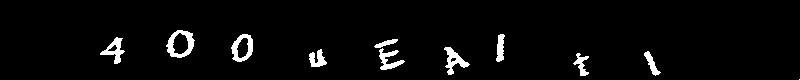

Epoch [0/5] Batch 95/121 Loss D: 1.1487, Loss G: 1.1443
Epoch [0/5] Batch 96/121 Loss D: 1.2999, Loss G: 1.0862
Epoch [0/5] Batch 97/121 Loss D: 1.1483, Loss G: 1.0503
Epoch [0/5] Batch 98/121 Loss D: 1.1678, Loss G: 1.1492
Epoch [0/5] Batch 99/121 Loss D: 1.1891, Loss G: 1.1420


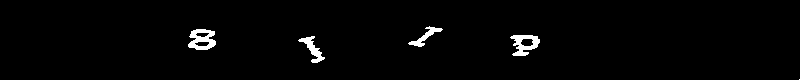

Epoch [0/5] Batch 100/121 Loss D: 1.0584, Loss G: 1.1456
Epoch [0/5] Batch 101/121 Loss D: 1.2413, Loss G: 1.1689
Epoch [0/5] Batch 102/121 Loss D: 1.0946, Loss G: 0.9901
Epoch [0/5] Batch 103/121 Loss D: 1.2502, Loss G: 1.0549
Epoch [0/5] Batch 104/121 Loss D: 1.2069, Loss G: 1.2448


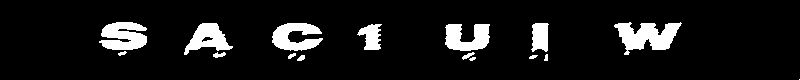

Epoch [0/5] Batch 105/121 Loss D: 1.0933, Loss G: 0.9391
Epoch [0/5] Batch 106/121 Loss D: 1.2215, Loss G: 0.9511
Epoch [0/5] Batch 107/121 Loss D: 1.1991, Loss G: 1.2796
Epoch [0/5] Batch 108/121 Loss D: 1.2029, Loss G: 1.0761
Epoch [0/5] Batch 109/121 Loss D: 1.1664, Loss G: 0.9954


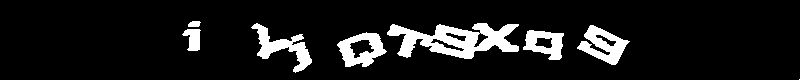

Epoch [0/5] Batch 110/121 Loss D: 1.1668, Loss G: 1.0586
Epoch [0/5] Batch 111/121 Loss D: 1.1251, Loss G: 1.1946
Epoch [0/5] Batch 112/121 Loss D: 1.0972, Loss G: 0.8985
Epoch [0/5] Batch 113/121 Loss D: 1.0530, Loss G: 1.2913
Epoch [0/5] Batch 114/121 Loss D: 1.0819, Loss G: 1.2172


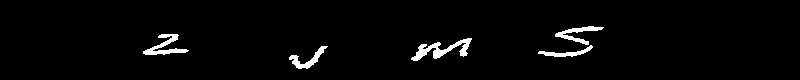

Epoch [0/5] Batch 115/121 Loss D: 1.0739, Loss G: 1.1950
Epoch [0/5] Batch 116/121 Loss D: 1.0741, Loss G: 0.9572
Epoch [0/5] Batch 117/121 Loss D: 1.0191, Loss G: 1.6019
Epoch [0/5] Batch 118/121 Loss D: 1.1575, Loss G: 0.9761
Epoch [0/5] Batch 119/121 Loss D: 1.1406, Loss G: 1.5641


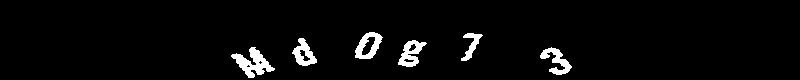

Epoch [0/5] Batch 120/121 Loss D: 1.1667, Loss G: 0.8303


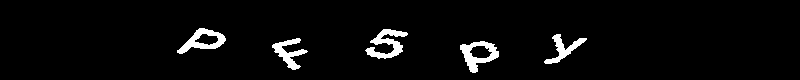

Epoch [1/5] Batch 0/121 Loss D: 1.1384, Loss G: 1.1727
Epoch [1/5] Batch 1/121 Loss D: 1.1129, Loss G: 1.2469
Epoch [1/5] Batch 2/121 Loss D: 1.0346, Loss G: 0.8645
Epoch [1/5] Batch 3/121 Loss D: 1.2060, Loss G: 1.4088
Epoch [1/5] Batch 4/121 Loss D: 1.1456, Loss G: 1.1448


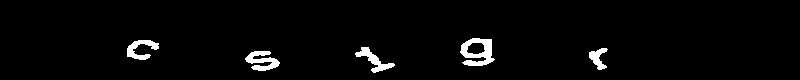

Epoch [1/5] Batch 5/121 Loss D: 1.1426, Loss G: 1.0077
Epoch [1/5] Batch 6/121 Loss D: 1.1268, Loss G: 1.1313
Epoch [1/5] Batch 7/121 Loss D: 1.0510, Loss G: 1.1792
Epoch [1/5] Batch 8/121 Loss D: 1.1815, Loss G: 1.1029
Epoch [1/5] Batch 9/121 Loss D: 1.0756, Loss G: 1.0314


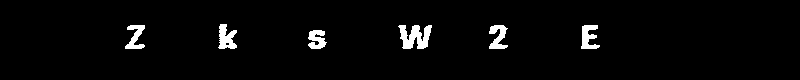

Epoch [1/5] Batch 10/121 Loss D: 1.1857, Loss G: 1.1561
Epoch [1/5] Batch 11/121 Loss D: 1.0754, Loss G: 1.1866
Epoch [1/5] Batch 12/121 Loss D: 1.0635, Loss G: 1.0664
Epoch [1/5] Batch 13/121 Loss D: 1.0115, Loss G: 1.3772
Epoch [1/5] Batch 14/121 Loss D: 1.0757, Loss G: 0.8674


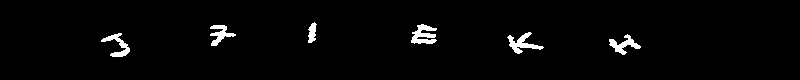

Epoch [1/5] Batch 15/121 Loss D: 1.1792, Loss G: 1.7286
Epoch [1/5] Batch 16/121 Loss D: 1.1740, Loss G: 0.8694
Epoch [1/5] Batch 17/121 Loss D: 1.1518, Loss G: 1.3242
Epoch [1/5] Batch 18/121 Loss D: 1.0051, Loss G: 1.4176
Epoch [1/5] Batch 19/121 Loss D: 1.1263, Loss G: 0.8213


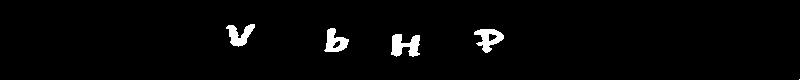

Epoch [1/5] Batch 20/121 Loss D: 1.1938, Loss G: 1.6910
Epoch [1/5] Batch 21/121 Loss D: 1.2385, Loss G: 1.0473
Epoch [1/5] Batch 22/121 Loss D: 1.0878, Loss G: 0.9769
Epoch [1/5] Batch 23/121 Loss D: 1.0109, Loss G: 1.0795
Epoch [1/5] Batch 24/121 Loss D: 1.1103, Loss G: 1.2984


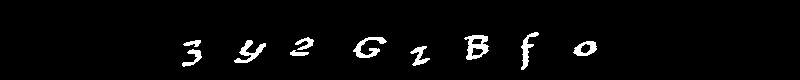

Epoch [1/5] Batch 25/121 Loss D: 1.1114, Loss G: 1.0953
Epoch [1/5] Batch 26/121 Loss D: 1.0349, Loss G: 1.1245
Epoch [1/5] Batch 27/121 Loss D: 0.9710, Loss G: 1.3111
Epoch [1/5] Batch 28/121 Loss D: 1.1002, Loss G: 1.4486
Epoch [1/5] Batch 29/121 Loss D: 1.0635, Loss G: 1.0515


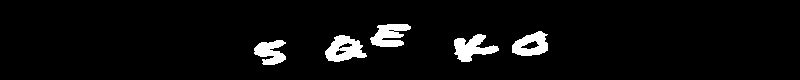

Epoch [1/5] Batch 30/121 Loss D: 1.0442, Loss G: 1.3203
Epoch [1/5] Batch 31/121 Loss D: 1.0187, Loss G: 1.1791
Epoch [1/5] Batch 32/121 Loss D: 1.0881, Loss G: 1.2109
Epoch [1/5] Batch 33/121 Loss D: 0.9506, Loss G: 1.3405
Epoch [1/5] Batch 34/121 Loss D: 1.0496, Loss G: 1.3373


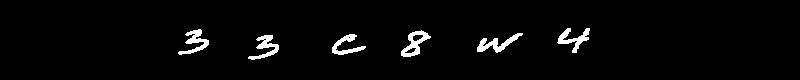

Epoch [1/5] Batch 35/121 Loss D: 0.9317, Loss G: 1.2286
Epoch [1/5] Batch 36/121 Loss D: 1.0150, Loss G: 1.6507
Epoch [1/5] Batch 37/121 Loss D: 1.1915, Loss G: 1.0458
Epoch [1/5] Batch 38/121 Loss D: 1.0747, Loss G: 1.0401
Epoch [1/5] Batch 39/121 Loss D: 1.0522, Loss G: 1.4063


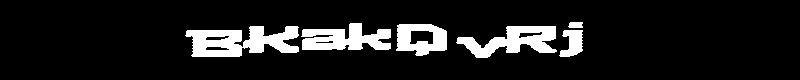

Epoch [1/5] Batch 40/121 Loss D: 0.9867, Loss G: 1.1510
Epoch [1/5] Batch 41/121 Loss D: 1.1698, Loss G: 1.3211
Epoch [1/5] Batch 42/121 Loss D: 1.1476, Loss G: 1.2229
Epoch [1/5] Batch 43/121 Loss D: 1.0207, Loss G: 1.1502
Epoch [1/5] Batch 44/121 Loss D: 1.1428, Loss G: 1.3804


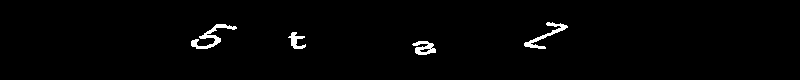

Epoch [1/5] Batch 45/121 Loss D: 1.0472, Loss G: 1.0473
Epoch [1/5] Batch 46/121 Loss D: 1.1552, Loss G: 1.3823
Epoch [1/5] Batch 47/121 Loss D: 1.0957, Loss G: 1.2429
Epoch [1/5] Batch 48/121 Loss D: 1.0170, Loss G: 1.0944
Epoch [1/5] Batch 49/121 Loss D: 1.0982, Loss G: 1.4135


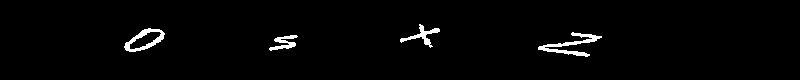

Epoch [1/5] Batch 50/121 Loss D: 1.0018, Loss G: 1.0526
Epoch [1/5] Batch 51/121 Loss D: 1.1961, Loss G: 1.5540
Epoch [1/5] Batch 52/121 Loss D: 1.1471, Loss G: 1.0892
Epoch [1/5] Batch 53/121 Loss D: 1.1495, Loss G: 1.3127
Epoch [1/5] Batch 54/121 Loss D: 1.0372, Loss G: 1.2752


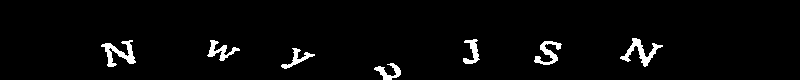

Epoch [1/5] Batch 55/121 Loss D: 1.0625, Loss G: 1.0530
Epoch [1/5] Batch 56/121 Loss D: 1.1768, Loss G: 1.3786
Epoch [1/5] Batch 57/121 Loss D: 0.9970, Loss G: 1.2870
Epoch [1/5] Batch 58/121 Loss D: 1.1194, Loss G: 1.2101
Epoch [1/5] Batch 59/121 Loss D: 1.2145, Loss G: 1.3158


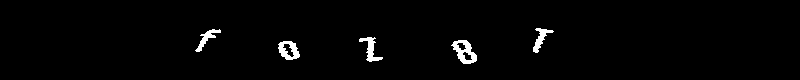

Epoch [1/5] Batch 60/121 Loss D: 1.1621, Loss G: 1.0420
Epoch [1/5] Batch 61/121 Loss D: 1.1601, Loss G: 1.2329
Epoch [1/5] Batch 62/121 Loss D: 1.0293, Loss G: 1.0989
Epoch [1/5] Batch 63/121 Loss D: 1.1380, Loss G: 1.3276
Epoch [1/5] Batch 64/121 Loss D: 1.1139, Loss G: 0.9838


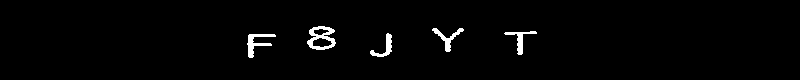

Epoch [1/5] Batch 65/121 Loss D: 1.1729, Loss G: 1.2815
Epoch [1/5] Batch 66/121 Loss D: 1.0267, Loss G: 1.1984
Epoch [1/5] Batch 67/121 Loss D: 1.1179, Loss G: 1.1130
Epoch [1/5] Batch 68/121 Loss D: 0.9917, Loss G: 1.0806
Epoch [1/5] Batch 69/121 Loss D: 1.1349, Loss G: 1.5079


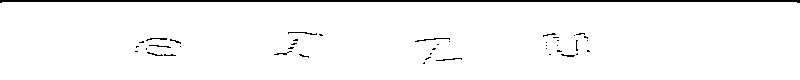

Epoch [1/5] Batch 70/121 Loss D: 1.0371, Loss G: 20.0497
Epoch [1/5] Batch 71/121 Loss D: 0.7470, Loss G: 23.2943
Epoch [1/5] Batch 72/121 Loss D: 0.1655, Loss G: 23.8016
Epoch [1/5] Batch 73/121 Loss D: 2.0700, Loss G: 0.7776
Epoch [1/5] Batch 74/121 Loss D: 1.2971, Loss G: 1.1630


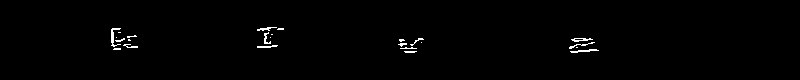

Epoch [1/5] Batch 75/121 Loss D: 1.0889, Loss G: 1.3224
Epoch [1/5] Batch 76/121 Loss D: 1.0883, Loss G: 1.1884
Epoch [1/5] Batch 77/121 Loss D: 0.9711, Loss G: 1.1263
Epoch [1/5] Batch 78/121 Loss D: 0.9452, Loss G: 1.3333
Epoch [1/5] Batch 79/121 Loss D: 0.9391, Loss G: 1.3066


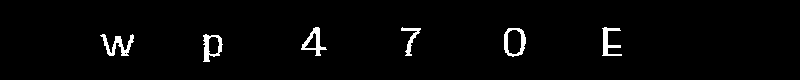

Epoch [1/5] Batch 80/121 Loss D: 0.9792, Loss G: 1.4105
Epoch [1/5] Batch 81/121 Loss D: 0.9038, Loss G: 1.4106
Epoch [1/5] Batch 82/121 Loss D: 0.9566, Loss G: 1.3217
Epoch [1/5] Batch 83/121 Loss D: 1.1030, Loss G: 1.4185
Epoch [1/5] Batch 84/121 Loss D: 1.1855, Loss G: 1.3832


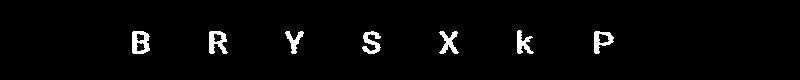

Epoch [1/5] Batch 85/121 Loss D: 0.9906, Loss G: 1.5328
Epoch [1/5] Batch 86/121 Loss D: 1.3758, Loss G: 1.2306
Epoch [1/5] Batch 87/121 Loss D: 1.0874, Loss G: 1.2930
Epoch [1/5] Batch 88/121 Loss D: 1.1572, Loss G: 1.2096
Epoch [1/5] Batch 89/121 Loss D: 1.2517, Loss G: 1.2947


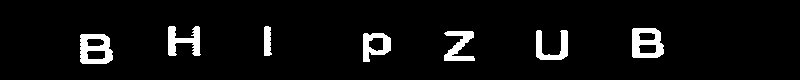

Epoch [1/5] Batch 90/121 Loss D: 1.0907, Loss G: 1.2799
Epoch [1/5] Batch 91/121 Loss D: 1.3196, Loss G: 1.1140
Epoch [1/5] Batch 92/121 Loss D: 1.1479, Loss G: 1.1306
Epoch [1/5] Batch 93/121 Loss D: 1.0298, Loss G: 1.2431
Epoch [1/5] Batch 94/121 Loss D: 1.2034, Loss G: 1.2166


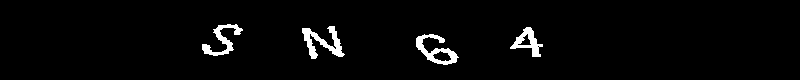

Epoch [1/5] Batch 95/121 Loss D: 1.2375, Loss G: 1.1295
Epoch [1/5] Batch 96/121 Loss D: 1.1114, Loss G: 1.2522
Epoch [1/5] Batch 97/121 Loss D: 1.1289, Loss G: 1.2187
Epoch [1/5] Batch 98/121 Loss D: 1.0985, Loss G: 1.2054
Epoch [1/5] Batch 99/121 Loss D: 1.1474, Loss G: 1.2103


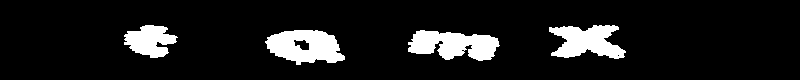

Epoch [1/5] Batch 100/121 Loss D: 1.1638, Loss G: 1.2562
Epoch [1/5] Batch 101/121 Loss D: 1.0185, Loss G: 1.2842
Epoch [1/5] Batch 102/121 Loss D: 1.1815, Loss G: 1.1016
Epoch [1/5] Batch 103/121 Loss D: 1.1250, Loss G: 1.2616
Epoch [1/5] Batch 104/121 Loss D: 1.0900, Loss G: 1.2335


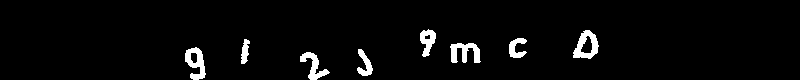

Epoch [1/5] Batch 105/121 Loss D: 1.0802, Loss G: 1.3032
Epoch [1/5] Batch 106/121 Loss D: 1.1487, Loss G: 1.2111
Epoch [1/5] Batch 107/121 Loss D: 1.1853, Loss G: 1.2532
Epoch [1/5] Batch 108/121 Loss D: 1.0925, Loss G: 1.2346
Epoch [1/5] Batch 109/121 Loss D: 1.0880, Loss G: 1.1023


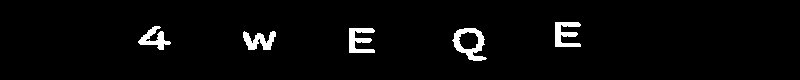

Epoch [1/5] Batch 110/121 Loss D: 1.1393, Loss G: 1.3131
Epoch [1/5] Batch 111/121 Loss D: 1.0086, Loss G: 1.3361
Epoch [1/5] Batch 112/121 Loss D: 1.1540, Loss G: 1.2076
Epoch [1/5] Batch 113/121 Loss D: 1.2138, Loss G: 1.1524
Epoch [1/5] Batch 114/121 Loss D: 1.1207, Loss G: 1.2633


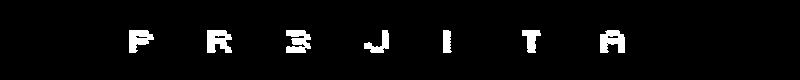

Epoch [1/5] Batch 115/121 Loss D: 1.1963, Loss G: 1.1448
Epoch [1/5] Batch 116/121 Loss D: 1.1333, Loss G: 1.1545
Epoch [1/5] Batch 117/121 Loss D: 1.0660, Loss G: 1.2654
Epoch [1/5] Batch 118/121 Loss D: 1.0591, Loss G: 1.2424
Epoch [1/5] Batch 119/121 Loss D: 1.1045, Loss G: 1.2031


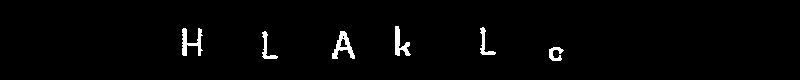

Epoch [1/5] Batch 120/121 Loss D: 1.0609, Loss G: 1.0733


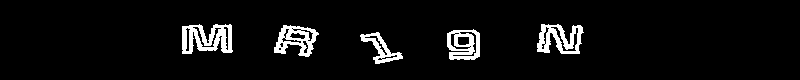

Epoch [2/5] Batch 0/121 Loss D: 1.2199, Loss G: 1.2046
Epoch [2/5] Batch 1/121 Loss D: 1.1180, Loss G: 1.2885
Epoch [2/5] Batch 2/121 Loss D: 1.0104, Loss G: 1.0984
Epoch [2/5] Batch 3/121 Loss D: 1.0360, Loss G: 1.1972
Epoch [2/5] Batch 4/121 Loss D: 0.9969, Loss G: 1.4636


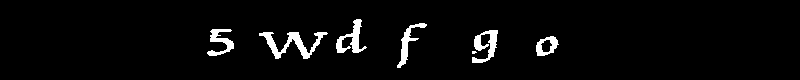

Epoch [2/5] Batch 5/121 Loss D: 1.0629, Loss G: 1.3591
Epoch [2/5] Batch 6/121 Loss D: 1.1188, Loss G: 1.2366
Epoch [2/5] Batch 7/121 Loss D: 0.9957, Loss G: 1.2190
Epoch [2/5] Batch 8/121 Loss D: 1.1319, Loss G: 1.2149
Epoch [2/5] Batch 9/121 Loss D: 1.0393, Loss G: 1.2481


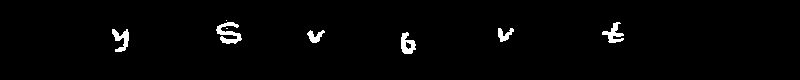

Epoch [2/5] Batch 10/121 Loss D: 1.1336, Loss G: 1.3073
Epoch [2/5] Batch 11/121 Loss D: 1.1340, Loss G: 1.0823
Epoch [2/5] Batch 12/121 Loss D: 1.1335, Loss G: 1.3454
Epoch [2/5] Batch 13/121 Loss D: 1.0734, Loss G: 1.1903
Epoch [2/5] Batch 14/121 Loss D: 1.0051, Loss G: 1.1394


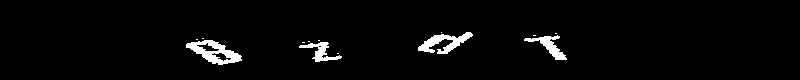

Epoch [2/5] Batch 15/121 Loss D: 1.0778, Loss G: 1.2326
Epoch [2/5] Batch 16/121 Loss D: 1.0947, Loss G: 1.2699
Epoch [2/5] Batch 17/121 Loss D: 1.0295, Loss G: 1.2296
Epoch [2/5] Batch 18/121 Loss D: 1.1754, Loss G: 1.3069
Epoch [2/5] Batch 19/121 Loss D: 1.1916, Loss G: 1.0177


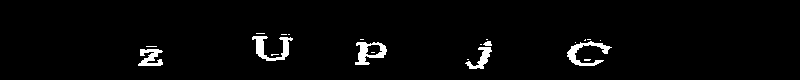

Epoch [2/5] Batch 20/121 Loss D: 1.1788, Loss G: 1.4146
Epoch [2/5] Batch 21/121 Loss D: 1.0691, Loss G: 1.1284
Epoch [2/5] Batch 22/121 Loss D: 1.0854, Loss G: 1.2958
Epoch [2/5] Batch 23/121 Loss D: 1.0131, Loss G: 1.2175
Epoch [2/5] Batch 24/121 Loss D: 1.0240, Loss G: 1.1472


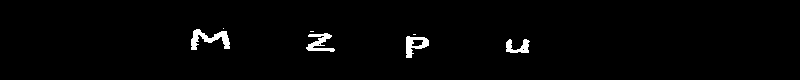

Epoch [2/5] Batch 25/121 Loss D: 1.0332, Loss G: 1.6281
Epoch [2/5] Batch 26/121 Loss D: 1.1291, Loss G: 1.0812
Epoch [2/5] Batch 27/121 Loss D: 0.9277, Loss G: 1.2454
Epoch [2/5] Batch 28/121 Loss D: 1.0637, Loss G: 1.5828
Epoch [2/5] Batch 29/121 Loss D: 0.9569, Loss G: 1.5025


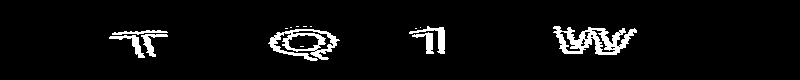

Epoch [2/5] Batch 30/121 Loss D: 1.0691, Loss G: 1.2468
Epoch [2/5] Batch 31/121 Loss D: 0.8809, Loss G: 1.5110
Epoch [2/5] Batch 32/121 Loss D: 1.1155, Loss G: 1.0371
Epoch [2/5] Batch 33/121 Loss D: 0.9919, Loss G: 1.3233
Epoch [2/5] Batch 34/121 Loss D: 1.0522, Loss G: 1.5531


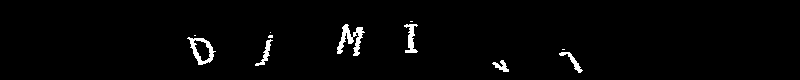

Epoch [2/5] Batch 35/121 Loss D: 1.0154, Loss G: 1.1966
Epoch [2/5] Batch 36/121 Loss D: 1.0590, Loss G: 1.3487
Epoch [2/5] Batch 37/121 Loss D: 1.0320, Loss G: 1.3202
Epoch [2/5] Batch 38/121 Loss D: 0.8808, Loss G: 1.5680
Epoch [2/5] Batch 39/121 Loss D: 1.0663, Loss G: 1.0678


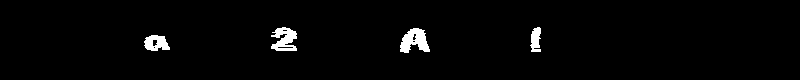

Epoch [2/5] Batch 40/121 Loss D: 1.2130, Loss G: 1.5295
Epoch [2/5] Batch 41/121 Loss D: 1.1512, Loss G: 1.0138
Epoch [2/5] Batch 42/121 Loss D: 0.9764, Loss G: 1.4129
Epoch [2/5] Batch 43/121 Loss D: 0.9499, Loss G: 1.4172
Epoch [2/5] Batch 44/121 Loss D: 1.0550, Loss G: 1.2249


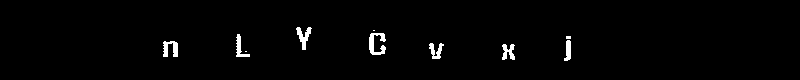

Epoch [2/5] Batch 45/121 Loss D: 1.1241, Loss G: 1.7798
Epoch [2/5] Batch 46/121 Loss D: 1.2329, Loss G: 0.9650
Epoch [2/5] Batch 47/121 Loss D: 1.0598, Loss G: 1.1372
Epoch [2/5] Batch 48/121 Loss D: 1.1215, Loss G: 1.5475
Epoch [2/5] Batch 49/121 Loss D: 1.1587, Loss G: 0.9042


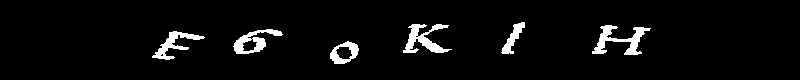

Epoch [2/5] Batch 50/121 Loss D: 1.1014, Loss G: 1.2139
Epoch [2/5] Batch 51/121 Loss D: 1.0042, Loss G: 1.5487
Epoch [2/5] Batch 52/121 Loss D: 1.0749, Loss G: 0.8011
Epoch [2/5] Batch 53/121 Loss D: 1.0681, Loss G: 1.3189
Epoch [2/5] Batch 54/121 Loss D: 1.1332, Loss G: 1.7780


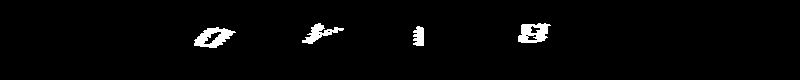

Epoch [2/5] Batch 55/121 Loss D: 1.2526, Loss G: 0.9415
Epoch [2/5] Batch 56/121 Loss D: 1.1706, Loss G: 1.2888
Epoch [2/5] Batch 57/121 Loss D: 0.9745, Loss G: 1.3225
Epoch [2/5] Batch 58/121 Loss D: 1.0267, Loss G: 1.1151
Epoch [2/5] Batch 59/121 Loss D: 1.0623, Loss G: 1.3022


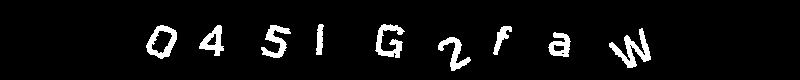

Epoch [2/5] Batch 60/121 Loss D: 0.9433, Loss G: 1.2600
Epoch [2/5] Batch 61/121 Loss D: 0.9614, Loss G: 1.2861
Epoch [2/5] Batch 62/121 Loss D: 1.0130, Loss G: 1.4474
Epoch [2/5] Batch 63/121 Loss D: 0.8685, Loss G: 1.2450
Epoch [2/5] Batch 64/121 Loss D: 0.9897, Loss G: 1.2272


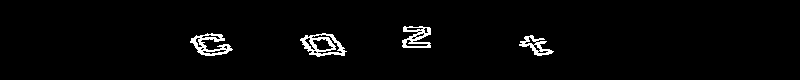

Epoch [2/5] Batch 65/121 Loss D: 1.0684, Loss G: 1.3192
Epoch [2/5] Batch 66/121 Loss D: 1.0437, Loss G: 0.9518
Epoch [2/5] Batch 67/121 Loss D: 0.9822, Loss G: 1.3820
Epoch [2/5] Batch 68/121 Loss D: 0.9935, Loss G: 1.6116
Epoch [2/5] Batch 69/121 Loss D: 0.9127, Loss G: 1.2602


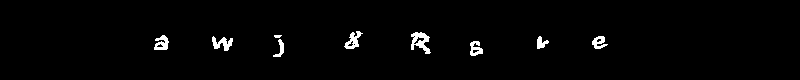

Epoch [2/5] Batch 70/121 Loss D: 1.0260, Loss G: 1.7082
Epoch [2/5] Batch 71/121 Loss D: 1.0570, Loss G: 1.1083
Epoch [2/5] Batch 72/121 Loss D: 0.9893, Loss G: 1.4353
Epoch [2/5] Batch 73/121 Loss D: 1.0598, Loss G: 1.4597
Epoch [2/5] Batch 74/121 Loss D: 1.0183, Loss G: 1.2495


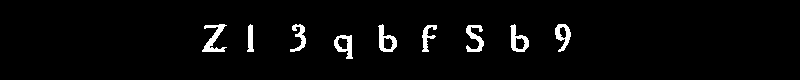

Epoch [2/5] Batch 75/121 Loss D: 0.8325, Loss G: 1.3966
Epoch [2/5] Batch 76/121 Loss D: 1.2074, Loss G: 1.4597
Epoch [2/5] Batch 77/121 Loss D: 1.0025, Loss G: 1.3052
Epoch [2/5] Batch 78/121 Loss D: 0.9615, Loss G: 1.3260
Epoch [2/5] Batch 79/121 Loss D: 0.9440, Loss G: 1.5381


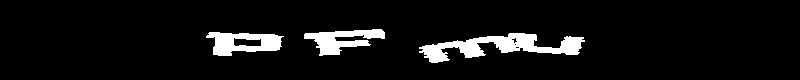

Epoch [2/5] Batch 80/121 Loss D: 1.0582, Loss G: 1.1628
Epoch [2/5] Batch 81/121 Loss D: 0.9688, Loss G: 1.2869
Epoch [2/5] Batch 82/121 Loss D: 1.1028, Loss G: 1.4964
Epoch [2/5] Batch 83/121 Loss D: 0.9638, Loss G: 1.0917
Epoch [2/5] Batch 84/121 Loss D: 1.2408, Loss G: 2.0955


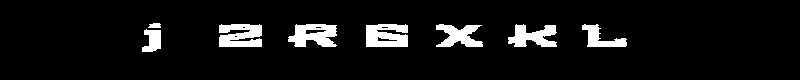

Epoch [2/5] Batch 85/121 Loss D: 1.1906, Loss G: 1.4830
Epoch [2/5] Batch 86/121 Loss D: 0.9370, Loss G: 1.1082
Epoch [2/5] Batch 87/121 Loss D: 1.2250, Loss G: 1.4632
Epoch [2/5] Batch 88/121 Loss D: 1.0099, Loss G: 1.5492
Epoch [2/5] Batch 89/121 Loss D: 1.0743, Loss G: 1.1556


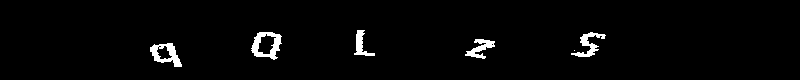

Epoch [2/5] Batch 90/121 Loss D: 0.9261, Loss G: 1.2174
Epoch [2/5] Batch 91/121 Loss D: 1.0301, Loss G: 1.4239
Epoch [2/5] Batch 92/121 Loss D: 0.9896, Loss G: 1.3235
Epoch [2/5] Batch 93/121 Loss D: 1.1504, Loss G: 1.3077
Epoch [2/5] Batch 94/121 Loss D: 0.9341, Loss G: 1.4191


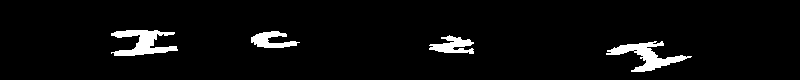

Epoch [2/5] Batch 95/121 Loss D: 0.9846, Loss G: 1.3261
Epoch [2/5] Batch 96/121 Loss D: 1.0975, Loss G: 1.4168
Epoch [2/5] Batch 97/121 Loss D: 1.0646, Loss G: 1.0868
Epoch [2/5] Batch 98/121 Loss D: 1.0463, Loss G: 1.4394
Epoch [2/5] Batch 99/121 Loss D: 0.9550, Loss G: 1.5495


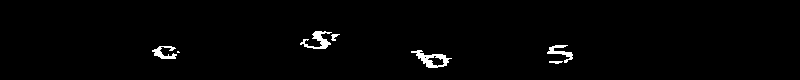

Epoch [2/5] Batch 100/121 Loss D: 0.9712, Loss G: 1.2503
Epoch [2/5] Batch 101/121 Loss D: 0.9346, Loss G: 1.2966
Epoch [2/5] Batch 102/121 Loss D: 1.0480, Loss G: 1.5694
Epoch [2/5] Batch 103/121 Loss D: 0.9357, Loss G: 1.4994
Epoch [2/5] Batch 104/121 Loss D: 1.0229, Loss G: 1.4094


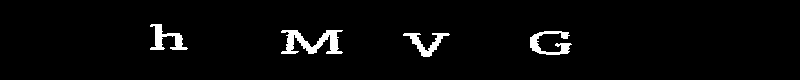

Epoch [2/5] Batch 105/121 Loss D: 1.1257, Loss G: 1.3828
Epoch [2/5] Batch 106/121 Loss D: 1.0384, Loss G: 1.3350
Epoch [2/5] Batch 107/121 Loss D: 0.8933, Loss G: 1.3471
Epoch [2/5] Batch 108/121 Loss D: 1.0170, Loss G: 1.4679
Epoch [2/5] Batch 109/121 Loss D: 0.8667, Loss G: 1.4677


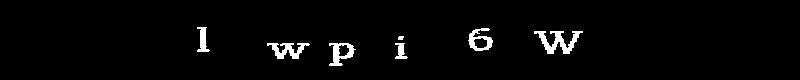

Epoch [2/5] Batch 110/121 Loss D: 1.0307, Loss G: 1.3506
Epoch [2/5] Batch 111/121 Loss D: 0.9859, Loss G: 1.3402
Epoch [2/5] Batch 112/121 Loss D: 0.9479, Loss G: 1.5301
Epoch [2/5] Batch 113/121 Loss D: 0.9710, Loss G: 1.4919
Epoch [2/5] Batch 114/121 Loss D: 1.0090, Loss G: 1.1994


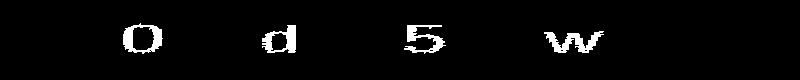

Epoch [2/5] Batch 115/121 Loss D: 1.0162, Loss G: 1.4279
Epoch [2/5] Batch 116/121 Loss D: 0.9946, Loss G: 1.7893
Epoch [2/5] Batch 117/121 Loss D: 1.1155, Loss G: 1.2291
Epoch [2/5] Batch 118/121 Loss D: 1.0671, Loss G: 1.5987
Epoch [2/5] Batch 119/121 Loss D: 0.8962, Loss G: 1.6224


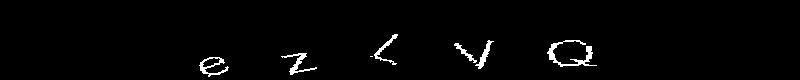

Epoch [2/5] Batch 120/121 Loss D: 1.0928, Loss G: 1.3945


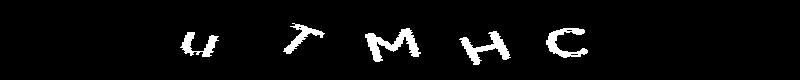

Epoch [3/5] Batch 0/121 Loss D: 1.0685, Loss G: 1.1575
Epoch [3/5] Batch 1/121 Loss D: 0.9646, Loss G: 1.4507
Epoch [3/5] Batch 2/121 Loss D: 1.0644, Loss G: 1.2879
Epoch [3/5] Batch 3/121 Loss D: 0.8063, Loss G: 1.3258
Epoch [3/5] Batch 4/121 Loss D: 1.0957, Loss G: 1.6337


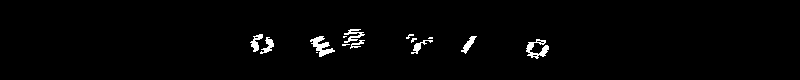

Epoch [3/5] Batch 5/121 Loss D: 1.0235, Loss G: 1.9143
Epoch [3/5] Batch 6/121 Loss D: 1.1109, Loss G: 1.6523
Epoch [3/5] Batch 7/121 Loss D: 0.8532, Loss G: 1.4380
Epoch [3/5] Batch 8/121 Loss D: 0.9910, Loss G: 1.6215
Epoch [3/5] Batch 9/121 Loss D: 1.0304, Loss G: 1.5359


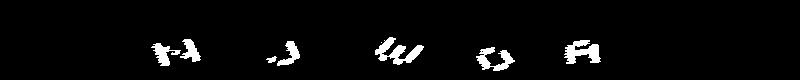

Epoch [3/5] Batch 10/121 Loss D: 0.9602, Loss G: 1.4667
Epoch [3/5] Batch 11/121 Loss D: 0.9408, Loss G: 1.5379
Epoch [3/5] Batch 12/121 Loss D: 0.9229, Loss G: 1.4638
Epoch [3/5] Batch 13/121 Loss D: 1.2480, Loss G: 1.4153
Epoch [3/5] Batch 14/121 Loss D: 1.0545, Loss G: 1.7257


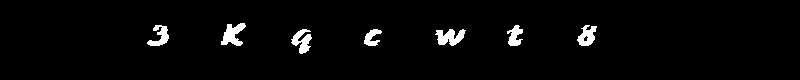

Epoch [3/5] Batch 15/121 Loss D: 1.2015, Loss G: 1.4172
Epoch [3/5] Batch 16/121 Loss D: 1.1863, Loss G: 1.4490
Epoch [3/5] Batch 17/121 Loss D: 0.9686, Loss G: 1.2104
Epoch [3/5] Batch 18/121 Loss D: 1.0326, Loss G: 1.2327
Epoch [3/5] Batch 19/121 Loss D: 1.0140, Loss G: 1.9273


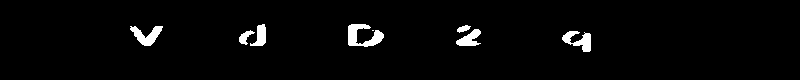

Epoch [3/5] Batch 20/121 Loss D: 1.1372, Loss G: 0.8865
Epoch [3/5] Batch 21/121 Loss D: 1.1807, Loss G: 1.5922
Epoch [3/5] Batch 22/121 Loss D: 1.0774, Loss G: 1.4270
Epoch [3/5] Batch 23/121 Loss D: 0.9226, Loss G: 1.2427
Epoch [3/5] Batch 24/121 Loss D: 1.0629, Loss G: 1.3646


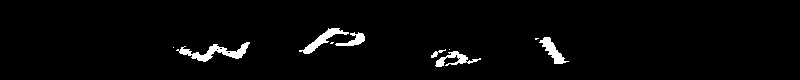

Epoch [3/5] Batch 25/121 Loss D: 0.9763, Loss G: 1.3529
Epoch [3/5] Batch 26/121 Loss D: 1.0792, Loss G: 1.3004
Epoch [3/5] Batch 27/121 Loss D: 0.9520, Loss G: 1.3173
Epoch [3/5] Batch 28/121 Loss D: 0.9744, Loss G: 1.2158
Epoch [3/5] Batch 29/121 Loss D: 1.0917, Loss G: 1.4771


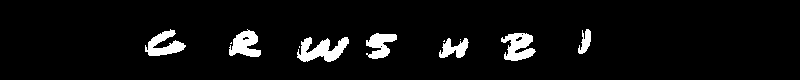

Epoch [3/5] Batch 30/121 Loss D: 1.0407, Loss G: 1.3970
Epoch [3/5] Batch 31/121 Loss D: 1.1219, Loss G: 1.2855
Epoch [3/5] Batch 32/121 Loss D: 1.1820, Loss G: 1.4894
Epoch [3/5] Batch 33/121 Loss D: 1.1626, Loss G: 1.3461
Epoch [3/5] Batch 34/121 Loss D: 1.1669, Loss G: 1.2359


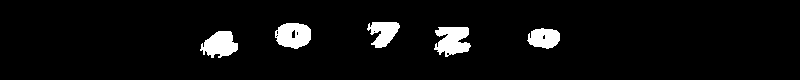

Epoch [3/5] Batch 35/121 Loss D: 1.1122, Loss G: 1.3827
Epoch [3/5] Batch 36/121 Loss D: 1.0032, Loss G: 1.4062
Epoch [3/5] Batch 37/121 Loss D: 1.4042, Loss G: 1.3550
Epoch [3/5] Batch 38/121 Loss D: 1.1804, Loss G: 1.2216
Epoch [3/5] Batch 39/121 Loss D: 1.0367, Loss G: 1.5376


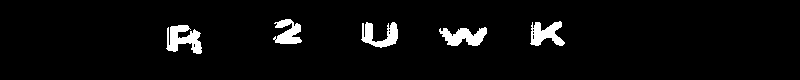

Epoch [3/5] Batch 40/121 Loss D: 1.1581, Loss G: 1.5810
Epoch [3/5] Batch 41/121 Loss D: 1.2541, Loss G: 1.2519
Epoch [3/5] Batch 42/121 Loss D: 1.3057, Loss G: 1.2519
Epoch [3/5] Batch 43/121 Loss D: 1.1953, Loss G: 1.2481
Epoch [3/5] Batch 44/121 Loss D: 1.2583, Loss G: 1.1501


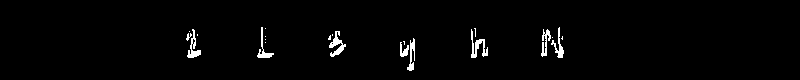

Epoch [3/5] Batch 45/121 Loss D: 1.1640, Loss G: 1.2142
Epoch [3/5] Batch 46/121 Loss D: 1.1407, Loss G: 1.3056
Epoch [3/5] Batch 47/121 Loss D: 1.1408, Loss G: 1.1637
Epoch [3/5] Batch 48/121 Loss D: 1.0612, Loss G: 1.4671
Epoch [3/5] Batch 49/121 Loss D: 1.1095, Loss G: 1.2054


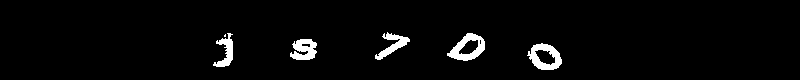

Epoch [3/5] Batch 50/121 Loss D: 1.1055, Loss G: 1.1131
Epoch [3/5] Batch 51/121 Loss D: 1.2036, Loss G: 1.1673
Epoch [3/5] Batch 52/121 Loss D: 1.0503, Loss G: 1.2836
Epoch [3/5] Batch 53/121 Loss D: 1.3332, Loss G: 1.2173
Epoch [3/5] Batch 54/121 Loss D: 1.1109, Loss G: 1.2242


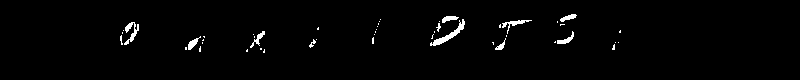

Epoch [3/5] Batch 55/121 Loss D: 1.0501, Loss G: 1.1870
Epoch [3/5] Batch 56/121 Loss D: 1.0640, Loss G: 1.2360
Epoch [3/5] Batch 57/121 Loss D: 1.1383, Loss G: 1.3166
Epoch [3/5] Batch 58/121 Loss D: 0.9985, Loss G: 1.2036
Epoch [3/5] Batch 59/121 Loss D: 1.1645, Loss G: 1.2556


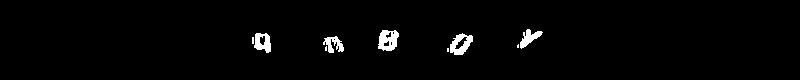

Epoch [3/5] Batch 60/121 Loss D: 1.0359, Loss G: 1.3944
Epoch [3/5] Batch 61/121 Loss D: 1.0588, Loss G: 1.2550
Epoch [3/5] Batch 62/121 Loss D: 1.0827, Loss G: 1.2413
Epoch [3/5] Batch 63/121 Loss D: 1.0975, Loss G: 1.3362
Epoch [3/5] Batch 64/121 Loss D: 1.0535, Loss G: 1.2790


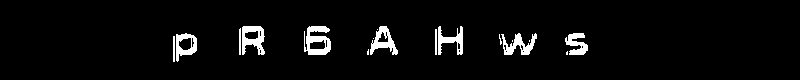

Epoch [3/5] Batch 65/121 Loss D: 0.9828, Loss G: 1.3905
Epoch [3/5] Batch 66/121 Loss D: 1.0379, Loss G: 1.2296
Epoch [3/5] Batch 67/121 Loss D: 1.0138, Loss G: 1.3486
Epoch [3/5] Batch 68/121 Loss D: 0.9491, Loss G: 1.4779
Epoch [3/5] Batch 69/121 Loss D: 1.1408, Loss G: 1.1640


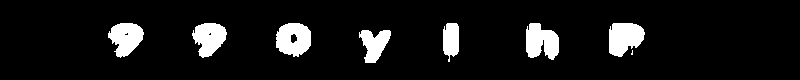

Epoch [3/5] Batch 70/121 Loss D: 1.0784, Loss G: 1.2550
Epoch [3/5] Batch 71/121 Loss D: 1.1013, Loss G: 1.4385
Epoch [3/5] Batch 72/121 Loss D: 1.0236, Loss G: 1.3077
Epoch [3/5] Batch 73/121 Loss D: 0.9808, Loss G: 1.3447
Epoch [3/5] Batch 74/121 Loss D: 1.0843, Loss G: 1.3550


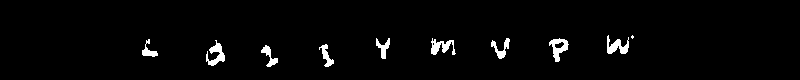

Epoch [3/5] Batch 75/121 Loss D: 0.9829, Loss G: 1.3506
Epoch [3/5] Batch 76/121 Loss D: 1.0129, Loss G: 1.3589
Epoch [3/5] Batch 77/121 Loss D: 1.1369, Loss G: 0.9355
Epoch [3/5] Batch 78/121 Loss D: 1.2163, Loss G: 1.7820
Epoch [3/5] Batch 79/121 Loss D: 1.3113, Loss G: 0.8408


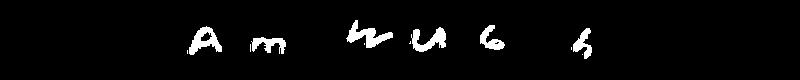

Epoch [3/5] Batch 80/121 Loss D: 1.0437, Loss G: 1.1033
Epoch [3/5] Batch 81/121 Loss D: 1.1048, Loss G: 1.3643
Epoch [3/5] Batch 82/121 Loss D: 0.9455, Loss G: 1.4030
Epoch [3/5] Batch 83/121 Loss D: 1.0272, Loss G: 1.3779
Epoch [3/5] Batch 84/121 Loss D: 1.0516, Loss G: 1.4679


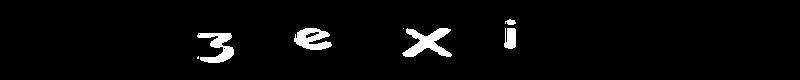

Epoch [3/5] Batch 85/121 Loss D: 1.0532, Loss G: 1.3659
Epoch [3/5] Batch 86/121 Loss D: 0.9011, Loss G: 1.4845
Epoch [3/5] Batch 87/121 Loss D: 1.2165, Loss G: 1.3088
Epoch [3/5] Batch 88/121 Loss D: 0.9833, Loss G: 1.4667
Epoch [3/5] Batch 89/121 Loss D: 1.0575, Loss G: 1.2251


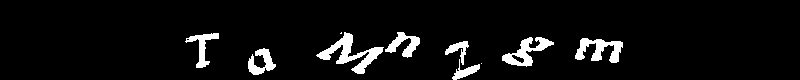

Epoch [3/5] Batch 90/121 Loss D: 1.0550, Loss G: 1.3353
Epoch [3/5] Batch 91/121 Loss D: 1.0225, Loss G: 1.4987
Epoch [3/5] Batch 92/121 Loss D: 1.1002, Loss G: 1.1594
Epoch [3/5] Batch 93/121 Loss D: 0.9971, Loss G: 1.3657
Epoch [3/5] Batch 94/121 Loss D: 1.0087, Loss G: 1.4326


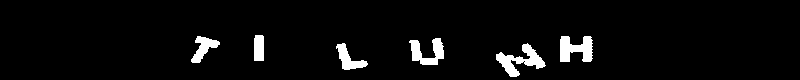

Epoch [3/5] Batch 95/121 Loss D: 1.1735, Loss G: 1.1641
Epoch [3/5] Batch 96/121 Loss D: 1.0648, Loss G: 1.3014
Epoch [3/5] Batch 97/121 Loss D: 1.0461, Loss G: 1.5618
Epoch [3/5] Batch 98/121 Loss D: 1.0700, Loss G: 1.2204
Epoch [3/5] Batch 99/121 Loss D: 0.9239, Loss G: 1.4232


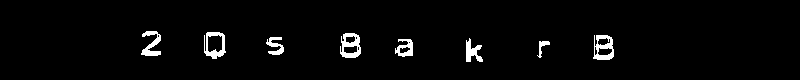

Epoch [3/5] Batch 100/121 Loss D: 1.1500, Loss G: 1.3067
Epoch [3/5] Batch 101/121 Loss D: 1.1428, Loss G: 1.2134
Epoch [3/5] Batch 102/121 Loss D: 0.9949, Loss G: 1.3339
Epoch [3/5] Batch 103/121 Loss D: 0.9910, Loss G: 1.2764
Epoch [3/5] Batch 104/121 Loss D: 0.9808, Loss G: 1.4523


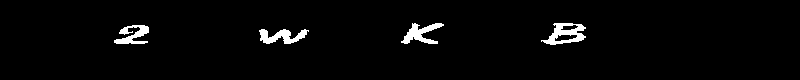

Epoch [3/5] Batch 105/121 Loss D: 0.9968, Loss G: 1.6289
Epoch [3/5] Batch 106/121 Loss D: 0.9987, Loss G: 1.3553
Epoch [3/5] Batch 107/121 Loss D: 0.8834, Loss G: 1.4456
Epoch [3/5] Batch 108/121 Loss D: 0.8991, Loss G: 1.5349
Epoch [3/5] Batch 109/121 Loss D: 1.1087, Loss G: 1.7990


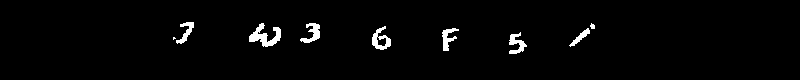

Epoch [3/5] Batch 110/121 Loss D: 1.0703, Loss G: 1.2232
Epoch [3/5] Batch 111/121 Loss D: 1.0985, Loss G: 1.6237
Epoch [3/5] Batch 112/121 Loss D: 1.0963, Loss G: 1.2577
Epoch [3/5] Batch 113/121 Loss D: 1.0321, Loss G: 1.1297
Epoch [3/5] Batch 114/121 Loss D: 1.1945, Loss G: 1.6466


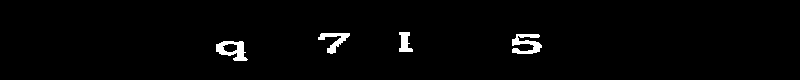

Epoch [3/5] Batch 115/121 Loss D: 1.1214, Loss G: 1.2770
Epoch [3/5] Batch 116/121 Loss D: 0.9363, Loss G: 1.2192
Epoch [3/5] Batch 117/121 Loss D: 1.0166, Loss G: 1.4340
Epoch [3/5] Batch 118/121 Loss D: 0.9693, Loss G: 1.4767
Epoch [3/5] Batch 119/121 Loss D: 1.1113, Loss G: 1.3702


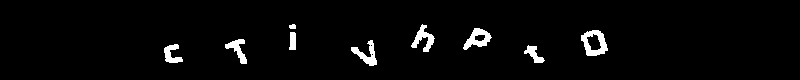

Epoch [3/5] Batch 120/121 Loss D: 0.9666, Loss G: 1.2161


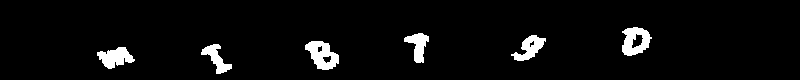

Epoch [4/5] Batch 0/121 Loss D: 1.0466, Loss G: 1.4865
Epoch [4/5] Batch 1/121 Loss D: 1.1662, Loss G: 1.3934
Epoch [4/5] Batch 2/121 Loss D: 1.1210, Loss G: 1.1740
Epoch [4/5] Batch 3/121 Loss D: 1.0709, Loss G: 1.2099
Epoch [4/5] Batch 4/121 Loss D: 1.0514, Loss G: 1.6760


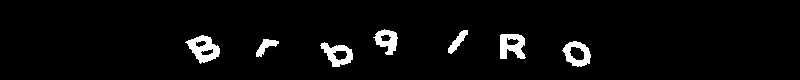

Epoch [4/5] Batch 5/121 Loss D: 1.0647, Loss G: 1.5537
Epoch [4/5] Batch 6/121 Loss D: 0.9080, Loss G: 1.3354
Epoch [4/5] Batch 7/121 Loss D: 0.9631, Loss G: 1.4329
Epoch [4/5] Batch 8/121 Loss D: 1.0331, Loss G: 1.5663
Epoch [4/5] Batch 9/121 Loss D: 0.9955, Loss G: 1.4009


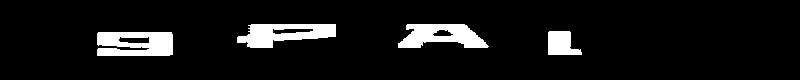

Epoch [4/5] Batch 10/121 Loss D: 0.9727, Loss G: 1.4970
Epoch [4/5] Batch 11/121 Loss D: 1.1187, Loss G: 1.2800
Epoch [4/5] Batch 12/121 Loss D: 1.0785, Loss G: 1.2427
Epoch [4/5] Batch 13/121 Loss D: 0.9684, Loss G: 1.3779
Epoch [4/5] Batch 14/121 Loss D: 1.0540, Loss G: 1.6905


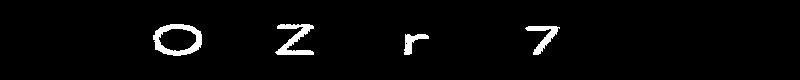

Epoch [4/5] Batch 15/121 Loss D: 1.0692, Loss G: 1.2729
Epoch [4/5] Batch 16/121 Loss D: 0.8957, Loss G: 1.5914
Epoch [4/5] Batch 17/121 Loss D: 0.9973, Loss G: 1.4312
Epoch [4/5] Batch 18/121 Loss D: 1.0006, Loss G: 1.4469
Epoch [4/5] Batch 19/121 Loss D: 1.1197, Loss G: 1.3459


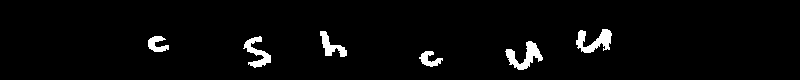

Epoch [4/5] Batch 20/121 Loss D: 1.0051, Loss G: 1.3440
Epoch [4/5] Batch 21/121 Loss D: 1.0537, Loss G: 1.3030
Epoch [4/5] Batch 22/121 Loss D: 0.9583, Loss G: 1.3747
Epoch [4/5] Batch 23/121 Loss D: 0.9233, Loss G: 1.6313
Epoch [4/5] Batch 24/121 Loss D: 0.9974, Loss G: 1.3364


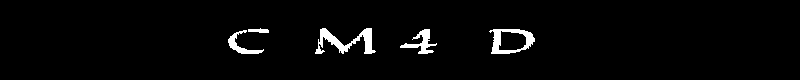

Epoch [4/5] Batch 25/121 Loss D: 1.0026, Loss G: 1.2943
Epoch [4/5] Batch 26/121 Loss D: 1.1614, Loss G: 1.4862
Epoch [4/5] Batch 27/121 Loss D: 0.9754, Loss G: 1.3321
Epoch [4/5] Batch 28/121 Loss D: 1.0757, Loss G: 1.6915
Epoch [4/5] Batch 29/121 Loss D: 1.2185, Loss G: 1.0841


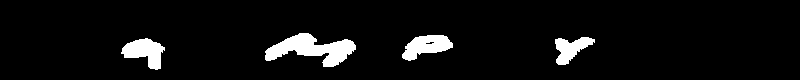

Epoch [4/5] Batch 30/121 Loss D: 1.0670, Loss G: 1.4185
Epoch [4/5] Batch 31/121 Loss D: 1.0553, Loss G: 1.2745
Epoch [4/5] Batch 32/121 Loss D: 0.9945, Loss G: 1.3373
Epoch [4/5] Batch 33/121 Loss D: 0.9826, Loss G: 1.3288
Epoch [4/5] Batch 34/121 Loss D: 0.9816, Loss G: 1.5969


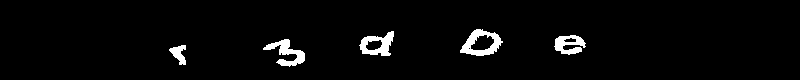

Epoch [4/5] Batch 35/121 Loss D: 1.1032, Loss G: 1.1052
Epoch [4/5] Batch 36/121 Loss D: 1.0168, Loss G: 1.3349
Epoch [4/5] Batch 37/121 Loss D: 0.9774, Loss G: 1.5992
Epoch [4/5] Batch 38/121 Loss D: 0.9471, Loss G: 1.2628
Epoch [4/5] Batch 39/121 Loss D: 1.0592, Loss G: 1.5624


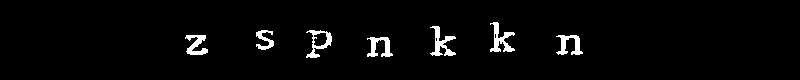

Epoch [4/5] Batch 40/121 Loss D: 0.9934, Loss G: 1.2448
Epoch [4/5] Batch 41/121 Loss D: 0.9492, Loss G: 1.6591
Epoch [4/5] Batch 42/121 Loss D: 0.8897, Loss G: 1.6220
Epoch [4/5] Batch 43/121 Loss D: 1.0483, Loss G: 1.7537
Epoch [4/5] Batch 44/121 Loss D: 1.0732, Loss G: 1.1760


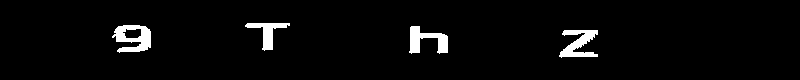

Epoch [4/5] Batch 45/121 Loss D: 1.3243, Loss G: 1.8695
Epoch [4/5] Batch 46/121 Loss D: 1.1859, Loss G: 1.2272
Epoch [4/5] Batch 47/121 Loss D: 1.0908, Loss G: 1.0929
Epoch [4/5] Batch 48/121 Loss D: 1.1044, Loss G: 1.7592
Epoch [4/5] Batch 49/121 Loss D: 0.9949, Loss G: 1.3570


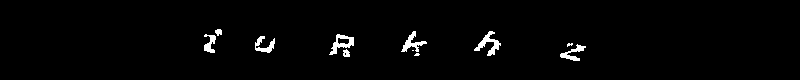

Epoch [4/5] Batch 50/121 Loss D: 1.0400, Loss G: 1.2187
Epoch [4/5] Batch 51/121 Loss D: 0.9678, Loss G: 1.6421
Epoch [4/5] Batch 52/121 Loss D: 1.0364, Loss G: 1.5572
Epoch [4/5] Batch 53/121 Loss D: 1.0503, Loss G: 1.3285
Epoch [4/5] Batch 54/121 Loss D: 0.9532, Loss G: 1.5641


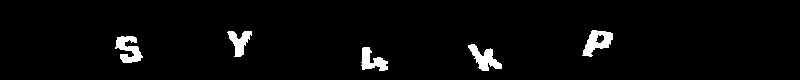

Epoch [4/5] Batch 55/121 Loss D: 0.9204, Loss G: 1.7075
Epoch [4/5] Batch 56/121 Loss D: 1.0951, Loss G: 1.1317
Epoch [4/5] Batch 57/121 Loss D: 1.4035, Loss G: 1.8118
Epoch [4/5] Batch 58/121 Loss D: 1.1889, Loss G: 1.3760
Epoch [4/5] Batch 59/121 Loss D: 1.0651, Loss G: 1.1809


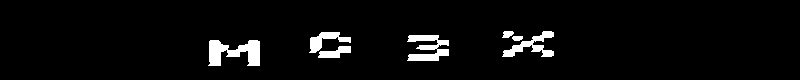

Epoch [4/5] Batch 60/121 Loss D: 1.0611, Loss G: 1.3633
Epoch [4/5] Batch 61/121 Loss D: 1.0506, Loss G: 1.3536
Epoch [4/5] Batch 62/121 Loss D: 0.9646, Loss G: 1.2960
Epoch [4/5] Batch 63/121 Loss D: 0.9841, Loss G: 1.2777
Epoch [4/5] Batch 64/121 Loss D: 1.0088, Loss G: 1.3542


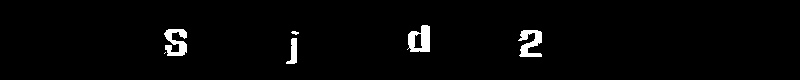

Epoch [4/5] Batch 65/121 Loss D: 1.0733, Loss G: 1.2679
Epoch [4/5] Batch 66/121 Loss D: 1.0096, Loss G: 1.4218
Epoch [4/5] Batch 67/121 Loss D: 1.0616, Loss G: 1.3859
Epoch [4/5] Batch 68/121 Loss D: 0.9859, Loss G: 1.4720
Epoch [4/5] Batch 69/121 Loss D: 0.7899, Loss G: 1.7003


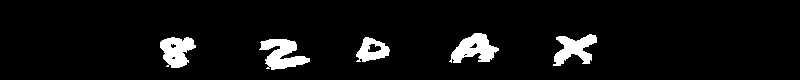

Epoch [4/5] Batch 70/121 Loss D: 0.8819, Loss G: 1.2955
Epoch [4/5] Batch 71/121 Loss D: 0.9325, Loss G: 1.5536
Epoch [4/5] Batch 72/121 Loss D: 0.9227, Loss G: 1.5985
Epoch [4/5] Batch 73/121 Loss D: 1.2486, Loss G: 1.7379
Epoch [4/5] Batch 74/121 Loss D: 1.0144, Loss G: 1.2318


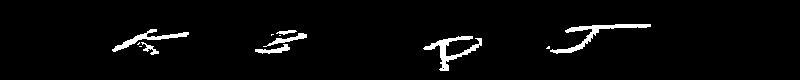

Epoch [4/5] Batch 75/121 Loss D: 1.1525, Loss G: 1.6802
Epoch [4/5] Batch 76/121 Loss D: 1.0766, Loss G: 1.1998
Epoch [4/5] Batch 77/121 Loss D: 1.0554, Loss G: 1.2721
Epoch [4/5] Batch 78/121 Loss D: 0.9109, Loss G: 1.6377
Epoch [4/5] Batch 79/121 Loss D: 1.0517, Loss G: 1.4551


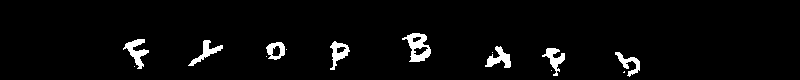

Epoch [4/5] Batch 80/121 Loss D: 0.9278, Loss G: 1.3184
Epoch [4/5] Batch 81/121 Loss D: 1.0187, Loss G: 1.4187
Epoch [4/5] Batch 82/121 Loss D: 0.9539, Loss G: 1.6659
Epoch [4/5] Batch 83/121 Loss D: 1.0202, Loss G: 1.3035
Epoch [4/5] Batch 84/121 Loss D: 1.0380, Loss G: 1.6656


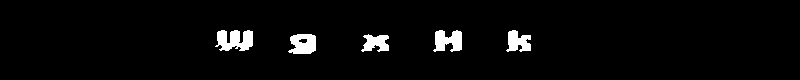

Epoch [4/5] Batch 85/121 Loss D: 1.0658, Loss G: 1.2830
Epoch [4/5] Batch 86/121 Loss D: 1.0306, Loss G: 1.4362
Epoch [4/5] Batch 87/121 Loss D: 0.9829, Loss G: 1.3774
Epoch [4/5] Batch 88/121 Loss D: 1.0285, Loss G: 1.5335
Epoch [4/5] Batch 89/121 Loss D: 0.9209, Loss G: 1.7380


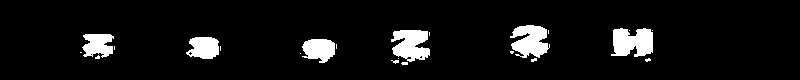

Epoch [4/5] Batch 90/121 Loss D: 1.1229, Loss G: 1.3573
Epoch [4/5] Batch 91/121 Loss D: 1.1038, Loss G: 1.4520
Epoch [4/5] Batch 92/121 Loss D: 0.9387, Loss G: 1.4826
Epoch [4/5] Batch 93/121 Loss D: 0.9375, Loss G: 1.5063
Epoch [4/5] Batch 94/121 Loss D: 0.9633, Loss G: 1.3904


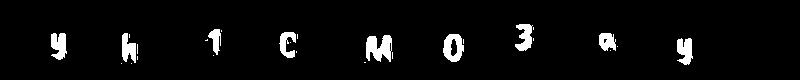

Epoch [4/5] Batch 95/121 Loss D: 0.9219, Loss G: 1.5023
Epoch [4/5] Batch 96/121 Loss D: 1.1068, Loss G: 1.7123
Epoch [4/5] Batch 97/121 Loss D: 0.9714, Loss G: 1.0459
Epoch [4/5] Batch 98/121 Loss D: 1.1869, Loss G: 1.9974
Epoch [4/5] Batch 99/121 Loss D: 1.0574, Loss G: 1.5038


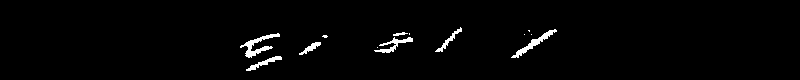

Epoch [4/5] Batch 100/121 Loss D: 1.0088, Loss G: 1.4154
Epoch [4/5] Batch 101/121 Loss D: 1.0344, Loss G: 1.3187
Epoch [4/5] Batch 102/121 Loss D: 0.8984, Loss G: 1.4602
Epoch [4/5] Batch 103/121 Loss D: 1.0274, Loss G: 1.5933
Epoch [4/5] Batch 104/121 Loss D: 1.0195, Loss G: 1.2978


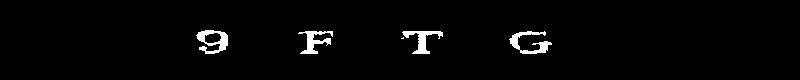

Epoch [4/5] Batch 105/121 Loss D: 0.9403, Loss G: 1.2663
Epoch [4/5] Batch 106/121 Loss D: 0.8294, Loss G: 1.7605
Epoch [4/5] Batch 107/121 Loss D: 0.9689, Loss G: 1.4690
Epoch [4/5] Batch 108/121 Loss D: 1.0395, Loss G: 1.5364
Epoch [4/5] Batch 109/121 Loss D: 1.0111, Loss G: 1.9535


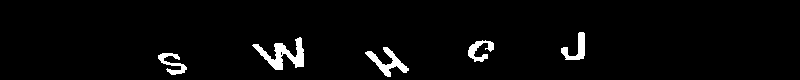

Epoch [4/5] Batch 110/121 Loss D: 1.0387, Loss G: 1.2399
Epoch [4/5] Batch 111/121 Loss D: 1.4999, Loss G: 1.2879
Epoch [4/5] Batch 112/121 Loss D: 0.9035, Loss G: 1.6761
Epoch [4/5] Batch 113/121 Loss D: 0.8684, Loss G: 1.3333
Epoch [4/5] Batch 114/121 Loss D: 0.9576, Loss G: 1.4866


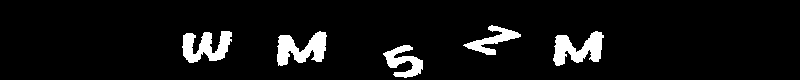

Epoch [4/5] Batch 115/121 Loss D: 0.9696, Loss G: 1.4282
Epoch [4/5] Batch 116/121 Loss D: 1.0423, Loss G: 1.6536
Epoch [4/5] Batch 117/121 Loss D: 0.9427, Loss G: 1.3716
Epoch [4/5] Batch 118/121 Loss D: 0.8307, Loss G: 1.3859
Epoch [4/5] Batch 119/121 Loss D: 0.8902, Loss G: 1.6597


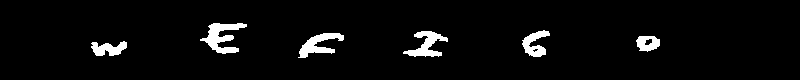

Epoch [4/5] Batch 120/121 Loss D: 0.9964, Loss G: 1.1826


In [71]:
for epoch in range(num_epochs):
    for i, images in enumerate(dataloader):
        real_imgs = images.to(device)
        b_size = real_imgs.size(0)

        # Labels
        y_true_real = torch.full((b_size, 1), 1.0, device=device)
        y_true_fake = torch.full((b_size, 1), 0.0, device=device)

        # Fake images
        fake_imgs = [transform(generate_random_captcha()) for _ in range(b_size)]
        fake_imgs = torch.stack(fake_imgs).reshape(b_size, 1, 80, 800).to(device)
        fake_imgs_refined = netG(fake_imgs) # go through generator to apply pixel-level adjustments

        if not i % 5:
            display_image(fake_imgs_refined[0].cpu().detach())

        # ---- Train Discriminator ----

        # Real images
        y_pred_real = netD(real_imgs).view(-1, 1)
        lossD_real = criterion(y_pred_real, y_true_real)
        y_pred_fake = netD(fake_imgs_refined.detach()).view(-1, 1)
        lossD_fake = criterion(y_pred_fake, y_true_fake)

        lossD = lossD_real + lossD_fake

        netD.zero_grad()
        optimizerD.zero_grad()
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        netG.zero_grad()
        netD.zero_grad()
        optimizerG.zero_grad()

        # Try to fool the discriminator
        y_pred_fake_for_G = netD(fake_imgs_refined).view(-1, 1)
        lossG_bce = criterion(y_pred_fake_for_G, y_true_real)
        lossG_self_reg = self_regularisation_loss(fake_imgs_refined, fake_imgs)
        lossG = lossG_bce + lossG_self_reg
        lossG.backward()
        optimizerG.step()

        if i % 1 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

tensor([[[[0.3132]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7801]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


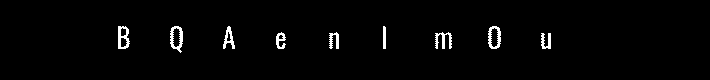

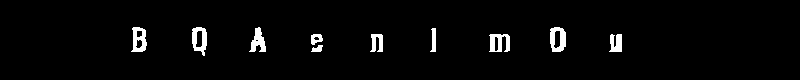

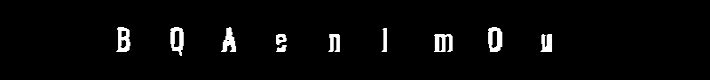

tensor([[[[0.6973]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


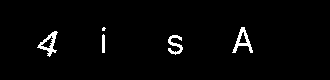

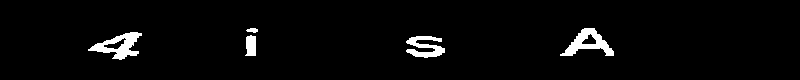

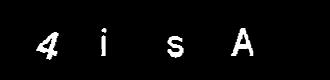

tensor([[[[0.7882]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


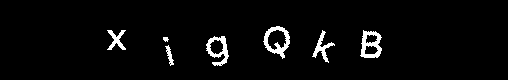

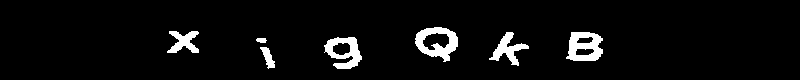

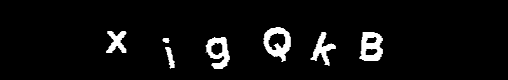

tensor([[[[0.4660]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8344]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


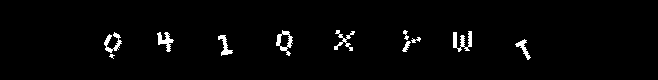

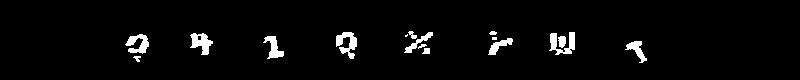

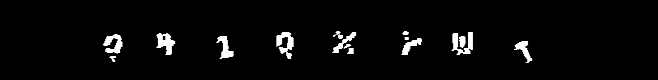

tensor([[[[0.8421]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


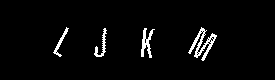

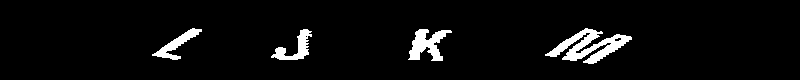

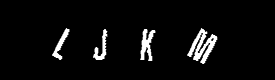

tensor([[[[0.6754]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


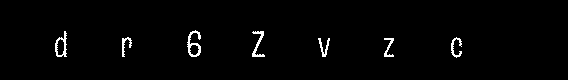

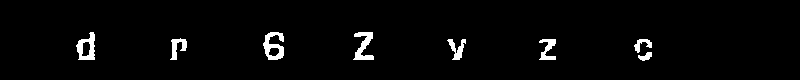

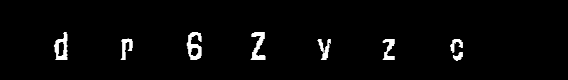

tensor([[[[0.2095]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1236]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.0937]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.0230]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6554]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


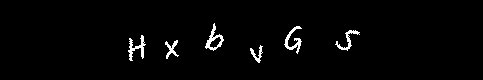

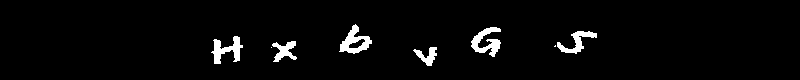

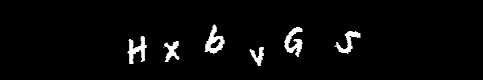

tensor([[[[0.1844]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3076]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7808]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


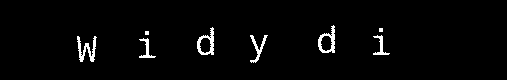

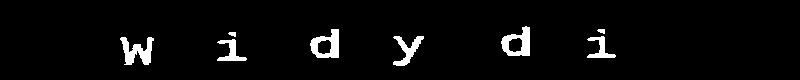

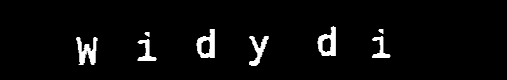

tensor([[[[0.7349]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


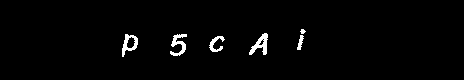

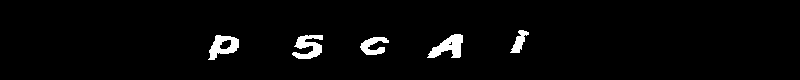

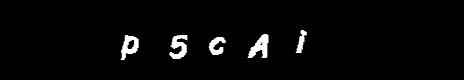

tensor([[[[0.4307]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2269]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5380]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8042]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


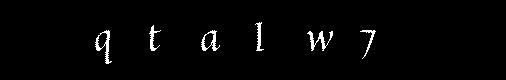

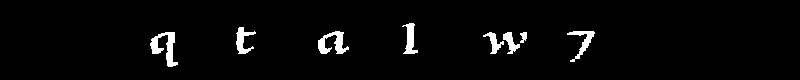

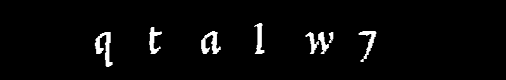

tensor([[[[0.7959]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


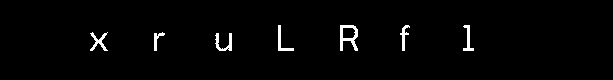

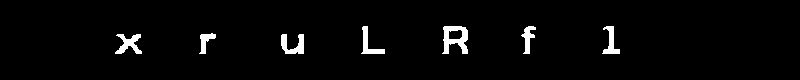

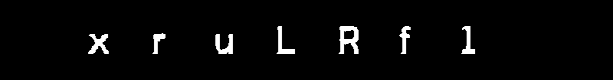

tensor([[[[0.4771]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9308]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


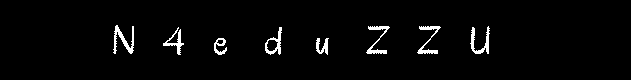

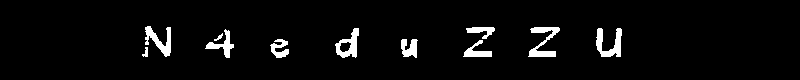

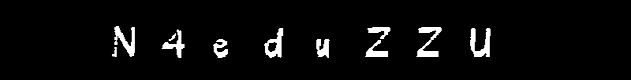

tensor([[[[0.3197]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3617]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2712]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4964]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4053]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4656]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8747]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


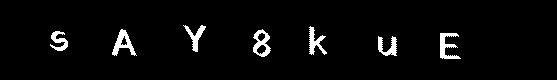

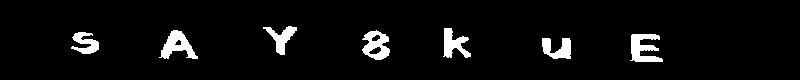

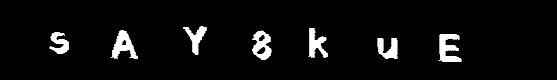

tensor([[[[0.7168]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


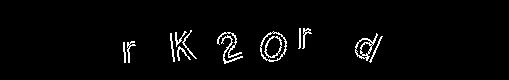

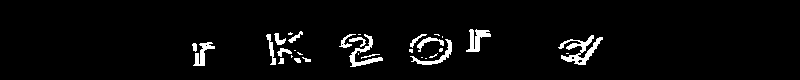

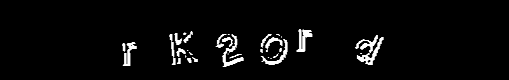

tensor([[[[0.1493]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4363]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3999]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7075]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


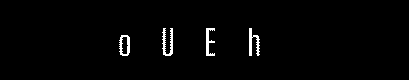

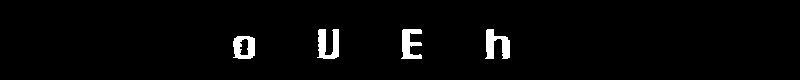

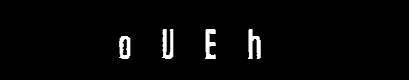

tensor([[[[0.0971]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5874]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5667]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5394]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1781]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7692]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


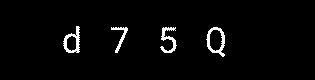

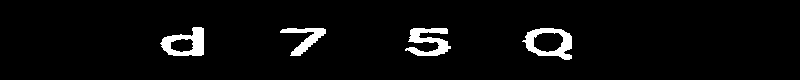

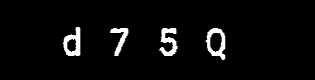

tensor([[[[0.2768]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9669]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


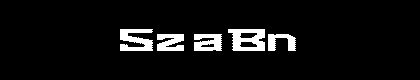

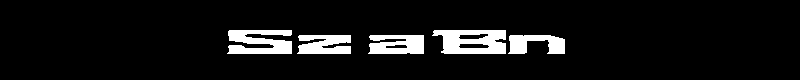

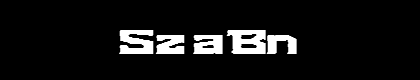

tensor([[[[0.3586]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6442]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


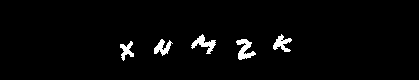

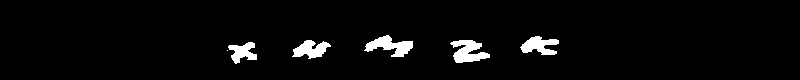

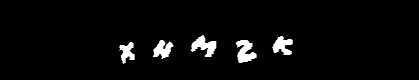

tensor([[[[0.0894]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4623]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2632]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6888]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


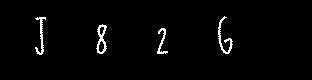

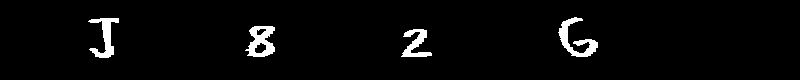

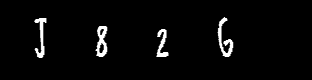

tensor([[[[0.6512]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


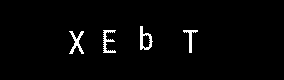

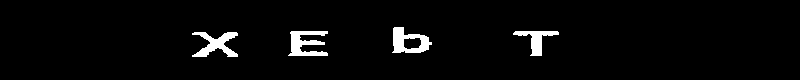

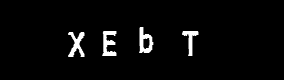

tensor([[[[0.4781]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3102]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.0026]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6169]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


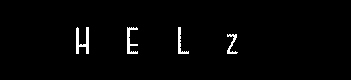

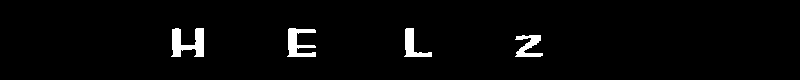

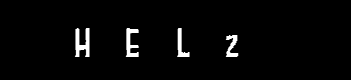

tensor([[[[0.8268]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


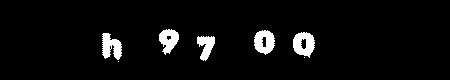

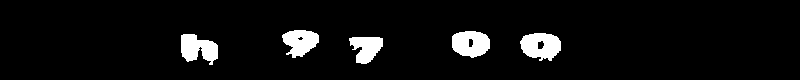

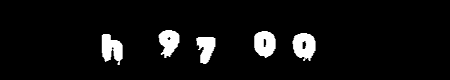

tensor([[[[0.1178]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9481]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


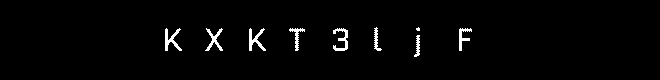

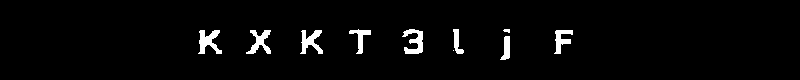

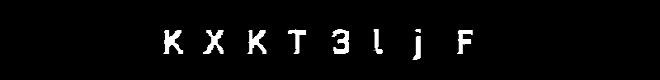

tensor([[[[0.2932]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9699]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


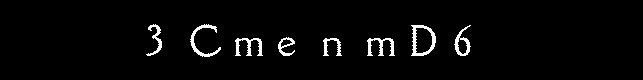

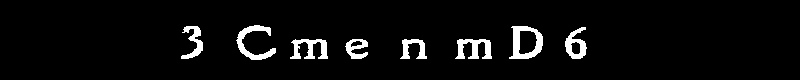

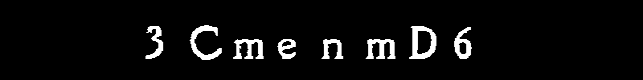

tensor([[[[0.3879]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6626]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


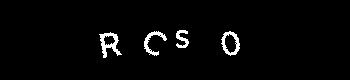

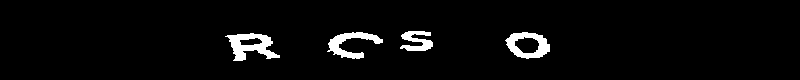

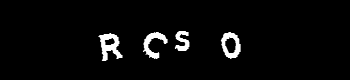

tensor([[[[0.6375]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


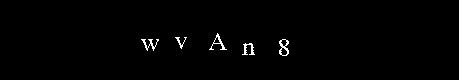

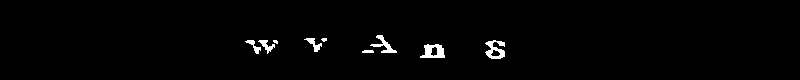

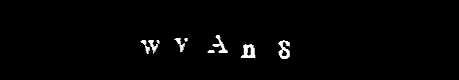

tensor([[[[0.0905]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6350]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


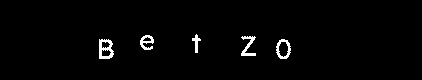

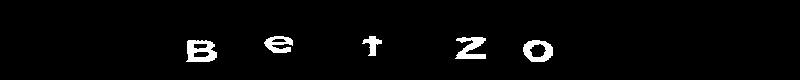

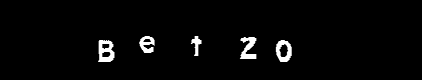

tensor([[[[0.7955]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


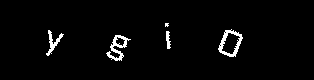

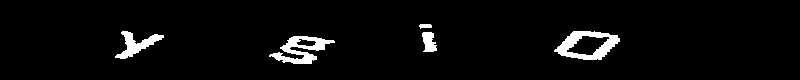

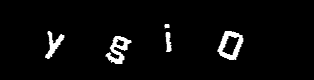

tensor([[[[0.4503]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3748]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3826]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6382]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


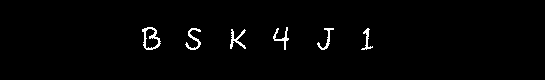

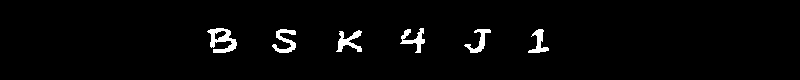

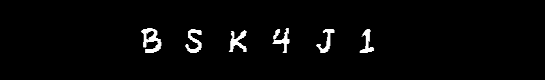

tensor([[[[0.6865]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


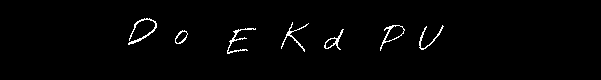

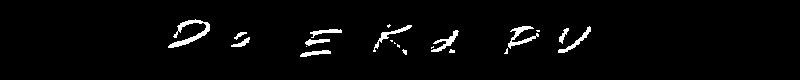

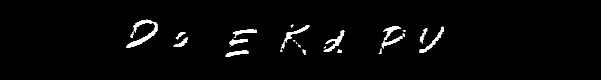

tensor([[[[0.2438]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5491]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5862]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8929]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


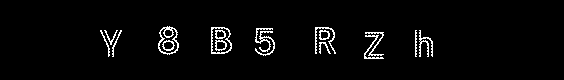

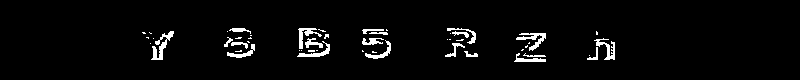

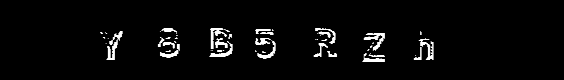

tensor([[[[0.4613]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8215]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


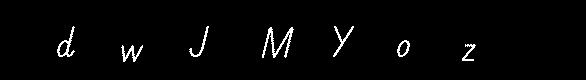

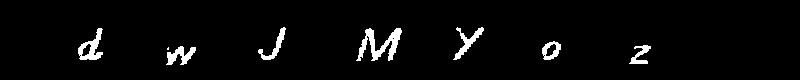

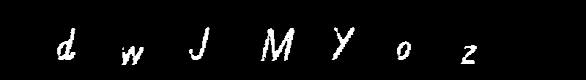

tensor([[[[0.9796]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


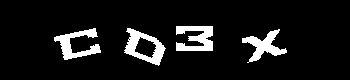

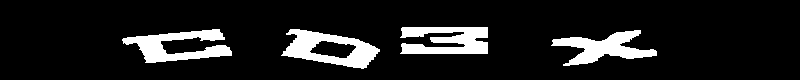

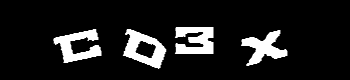

tensor([[[[0.7269]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


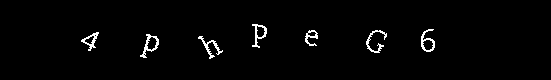

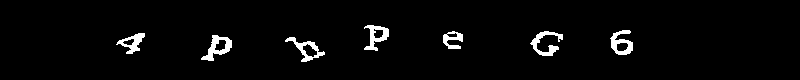

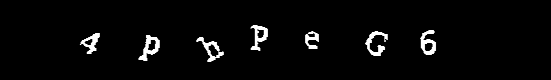

tensor([[[[0.2963]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8271]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


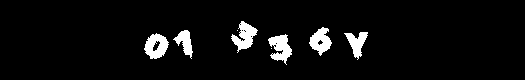

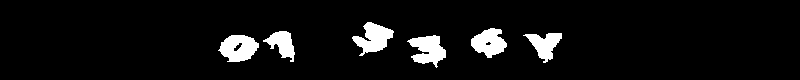

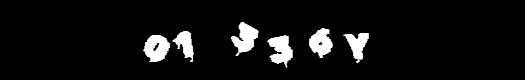

tensor([[[[0.0541]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6860]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


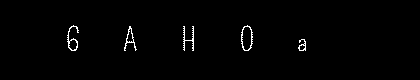

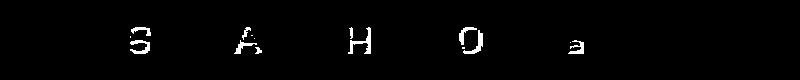

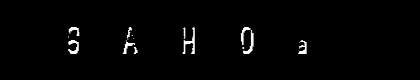

tensor([[[[0.6108]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


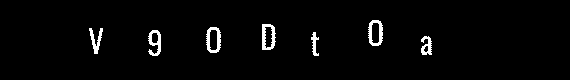

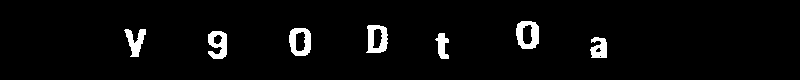

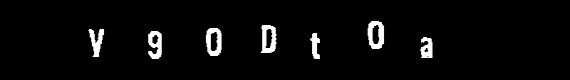

tensor([[[[0.3386]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4649]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4280]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5038]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6373]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


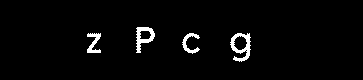

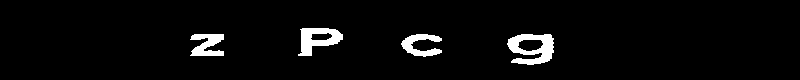

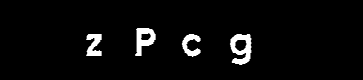

tensor([[[[0.3573]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9047]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


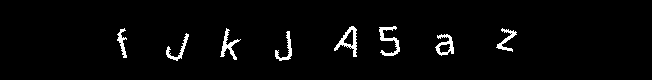

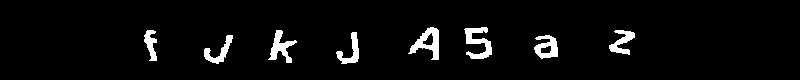

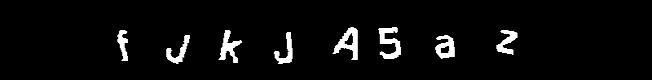

tensor([[[[0.4798]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3296]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4431]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2026]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5888]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7576]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


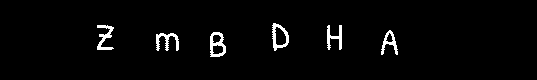

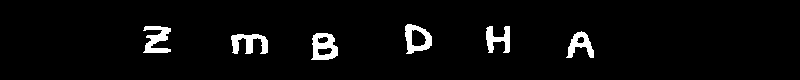

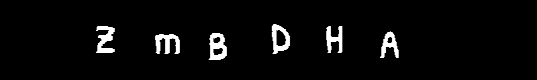

tensor([[[[0.7432]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


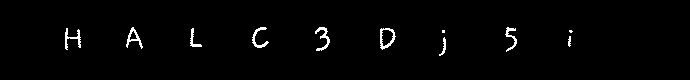

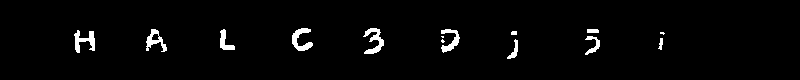

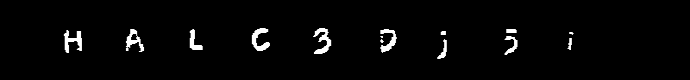

tensor([[[[0.7166]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


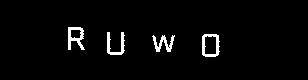

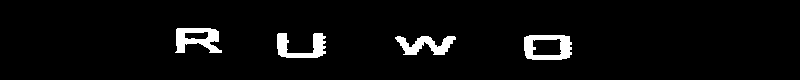

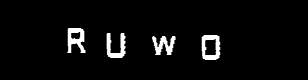

tensor([[[[0.1415]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [73]:
def display_image_ori_width(img_tensor, ori_width):
    img_array = ((img_tensor.numpy() * 0.5 + 0.5) * 255).astype(np.uint8)
    img_array[img_array < 128] = 0
    img_array[img_array >= 128] = 255
    display(Image.fromarray(img_array[0], 'L').resize((ori_width, 80), resample=3))

for _ in range(100):
  random_captcha = generate_random_captcha()
  width = random_captcha.size[0]
  generator_output = netG(torch.stack([transform(random_captcha)]).to(device))
  verdict = netD(generator_output)
  print(verdict)
  if verdict > 0.6:
    generator_output = generator_output[0].cpu().detach()
    display(random_captcha)
    display_image(generator_output)
    display_image_ori_width(generator_output, width)


## Export models

In [ ]:
NET_G_PATH = "./GAN/netG.pt"
NET_D_PATH = "./GAN/netD.pt"

In [77]:
torch.save(netG.state_dict(), NET_G_PATH)
torch.save(netD.state_dict(), NET_D_PATH)

## Import models

tensor([[[[0.5237]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5688]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5766]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7626]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


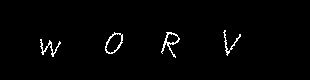

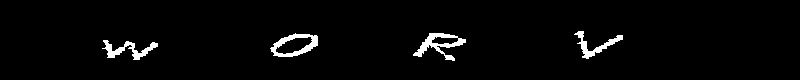

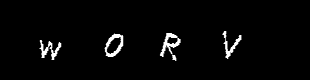

tensor([[[[0.4705]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7168]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


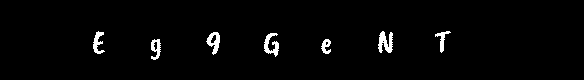

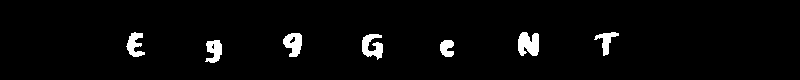

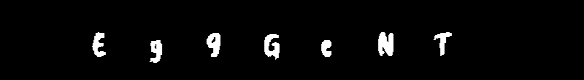

tensor([[[[0.3650]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5056]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4777]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7933]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


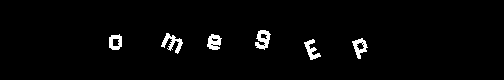

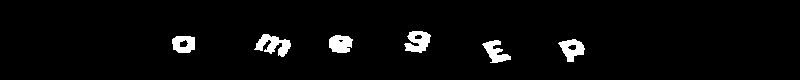

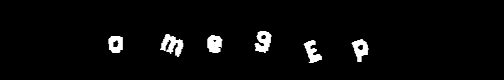

tensor([[[[0.8292]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


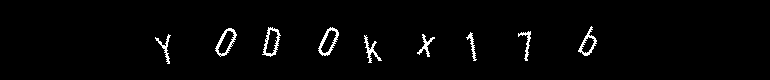

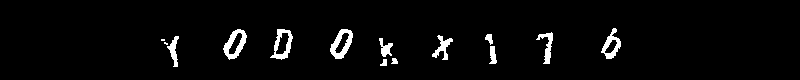

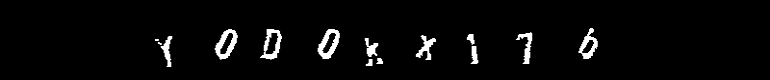

tensor([[[[0.5199]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3025]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6585]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


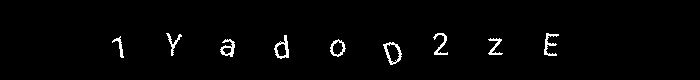

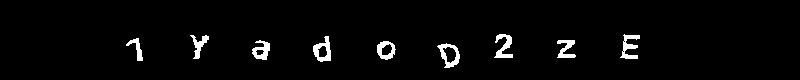

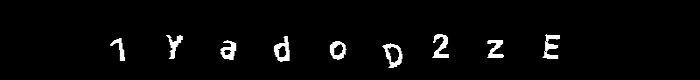

tensor([[[[0.2278]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8176]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


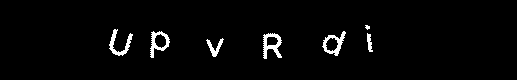

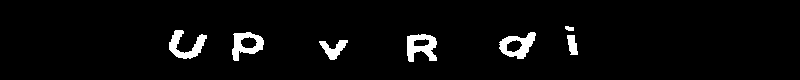

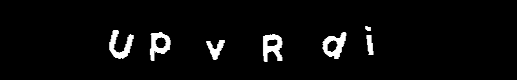

tensor([[[[0.2466]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4101]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6864]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


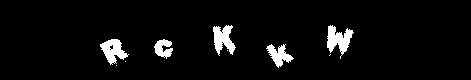

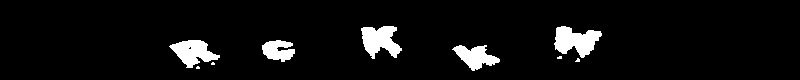

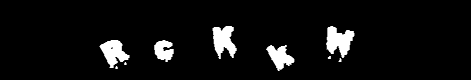

tensor([[[[0.8447]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


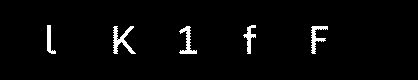

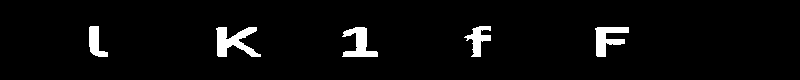

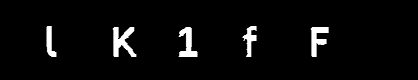

tensor([[[[0.1091]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3084]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7009]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


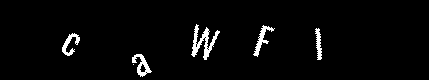

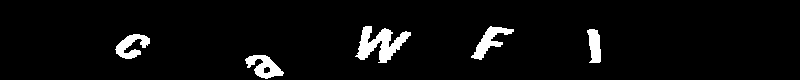

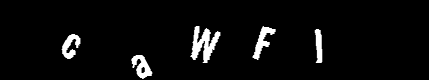

tensor([[[[0.3176]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5965]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2137]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6107]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


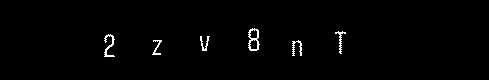

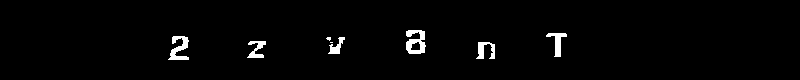

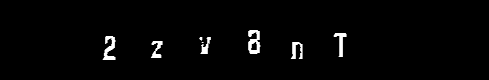

tensor([[[[0.2883]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3292]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8809]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


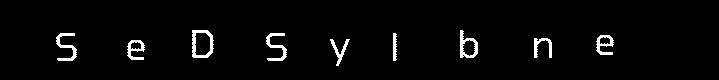

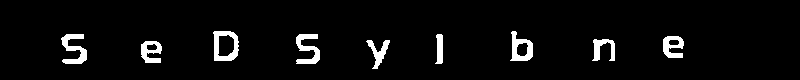

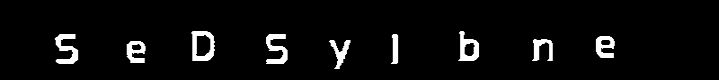

tensor([[[[0.3034]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5984]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3292]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8479]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


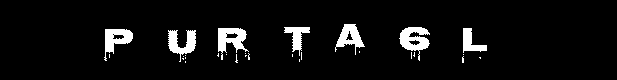

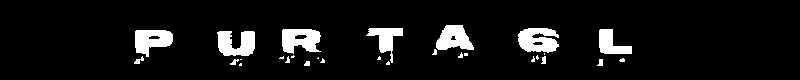

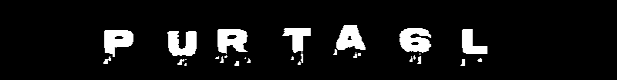

tensor([[[[0.8068]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


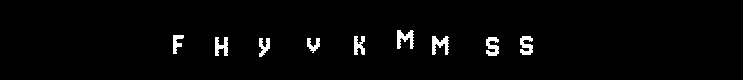

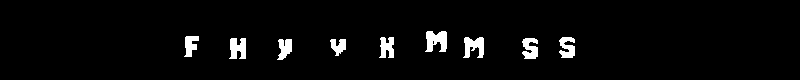

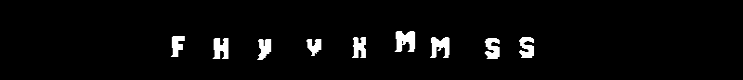

tensor([[[[0.2449]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2842]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8002]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


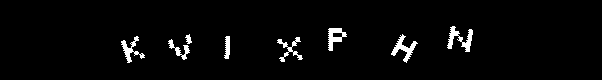

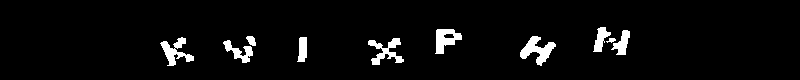

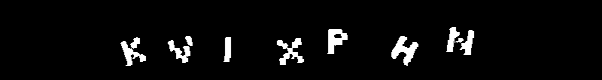

tensor([[[[0.6074]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


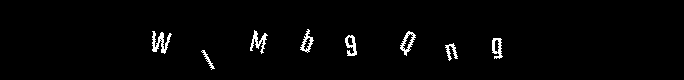

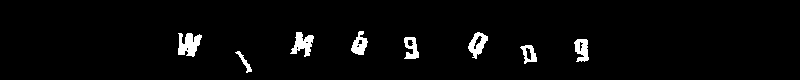

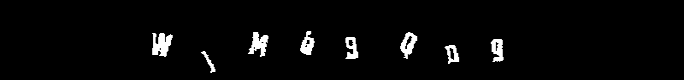

tensor([[[[0.1928]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4316]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4145]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6768]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


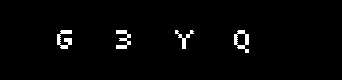

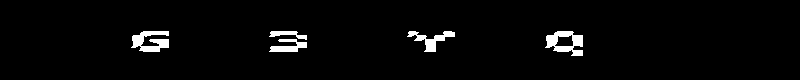

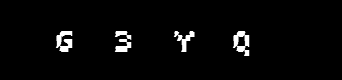

tensor([[[[0.7084]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


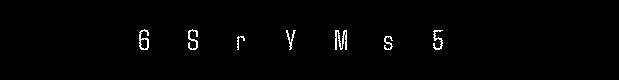

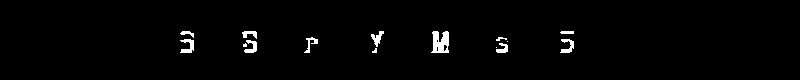

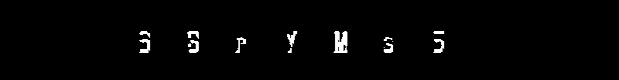

tensor([[[[0.3753]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2809]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7097]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


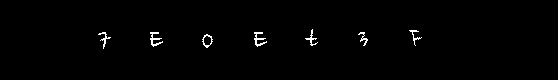

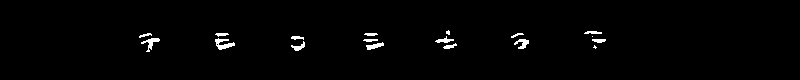

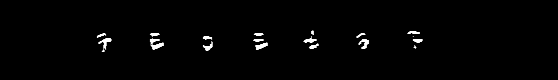

tensor([[[[0.4254]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.5815]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4142]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7373]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


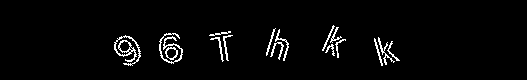

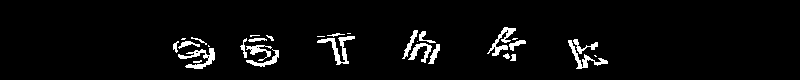

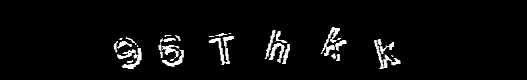

tensor([[[[0.6403]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


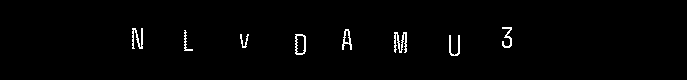

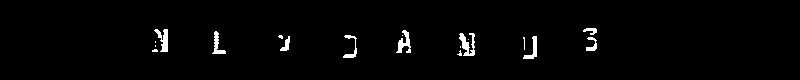

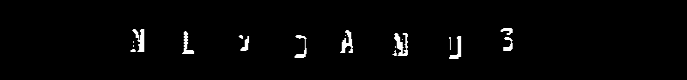

tensor([[[[0.6844]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


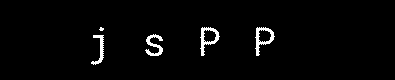

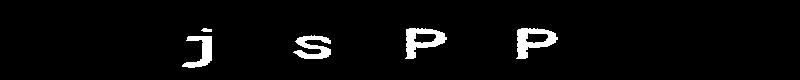

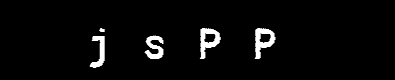

tensor([[[[0.2120]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4922]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9371]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


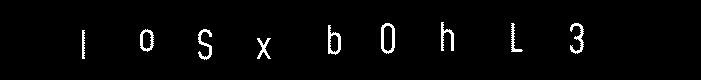

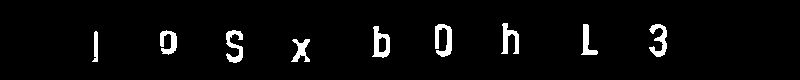

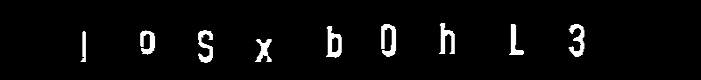

tensor([[[[0.5552]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.9959]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


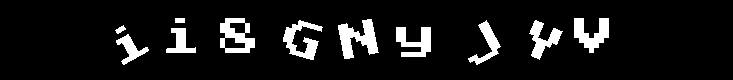

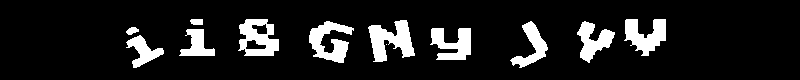

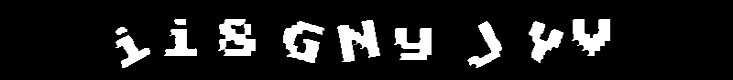

tensor([[[[0.8437]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


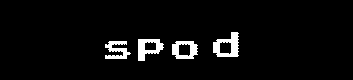

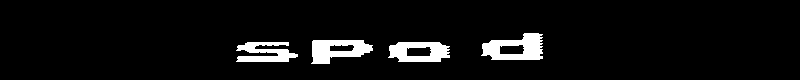

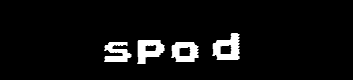

tensor([[[[0.5383]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8263]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


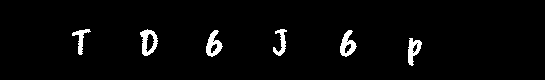

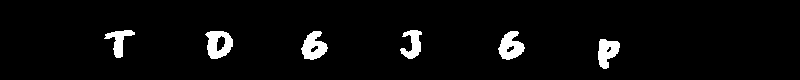

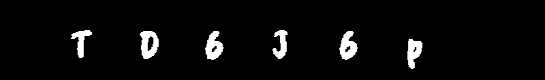

tensor([[[[0.4825]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4973]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4199]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7211]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


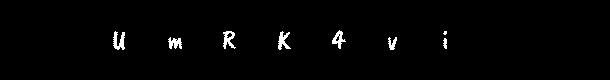

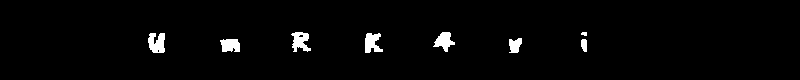

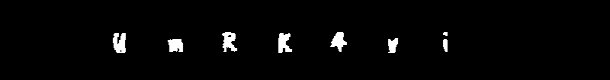

tensor([[[[0.5548]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2142]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8169]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


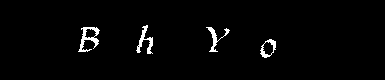

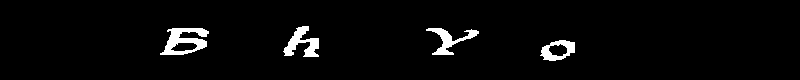

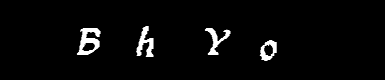

tensor([[[[0.4693]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.8011]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


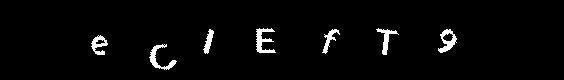

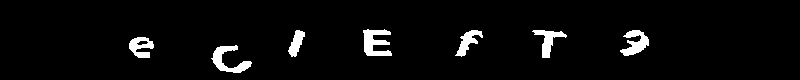

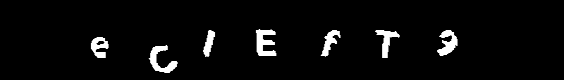

tensor([[[[0.3078]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6856]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


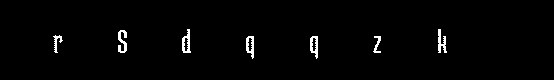

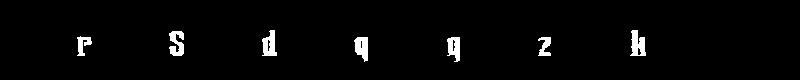

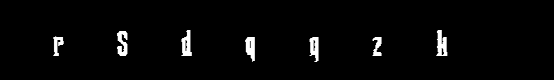

tensor([[[[0.3050]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7509]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


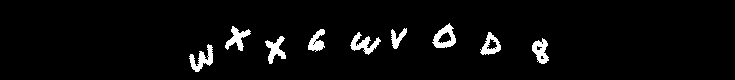

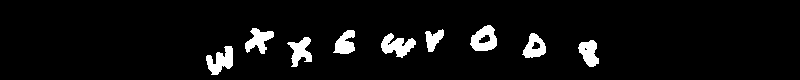

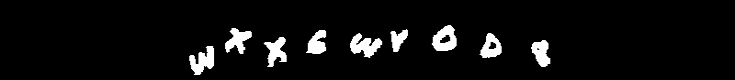

tensor([[[[0.0318]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.0423]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.4716]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6111]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


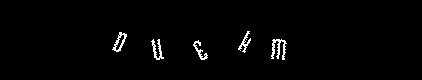

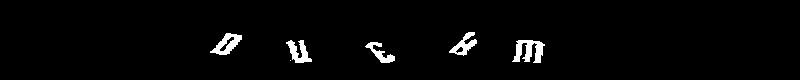

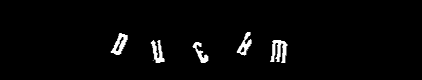

tensor([[[[0.8360]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


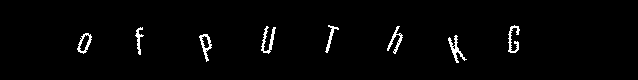

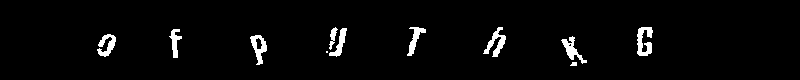

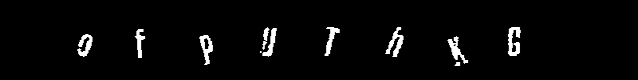

tensor([[[[0.6359]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


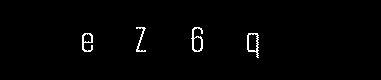

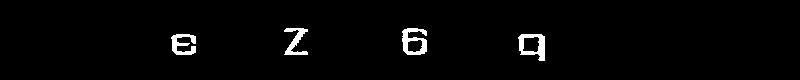

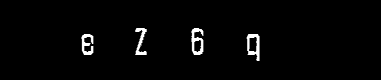

tensor([[[[0.8381]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


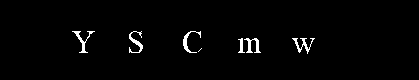

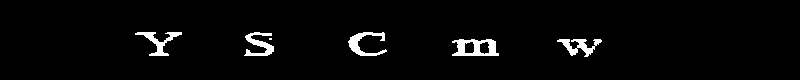

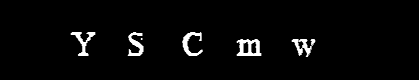

tensor([[[[0.3850]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.7209]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


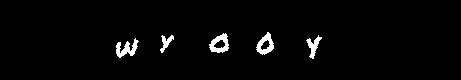

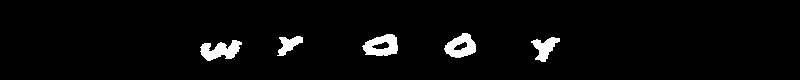

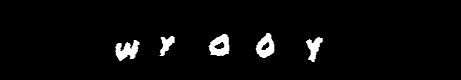

tensor([[[[0.3901]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3557]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3716]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1005]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2068]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.3687]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6475]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


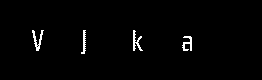

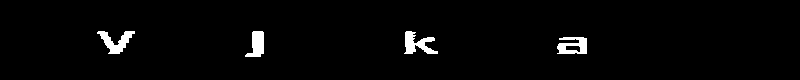

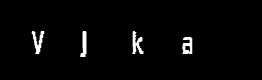

tensor([[[[0.7289]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


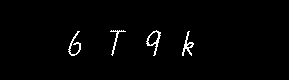

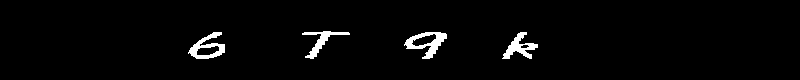

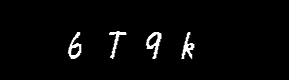

tensor([[[[0.5855]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.2578]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6381]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


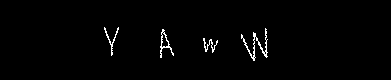

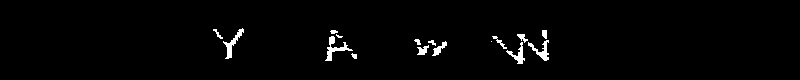

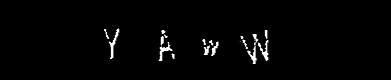

tensor([[[[0.6241]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


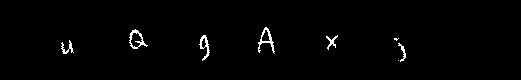

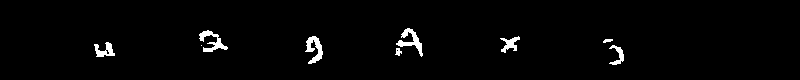

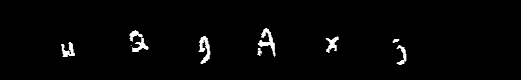

tensor([[[[0.6183]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


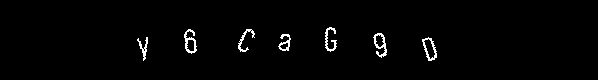

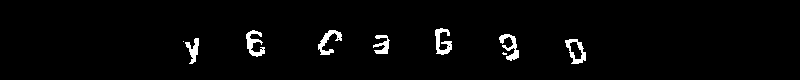

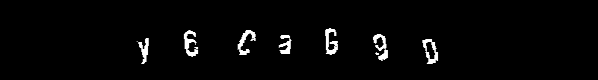

tensor([[[[0.1776]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.1985]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[[[0.6469]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


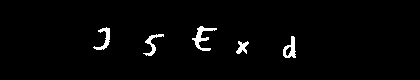

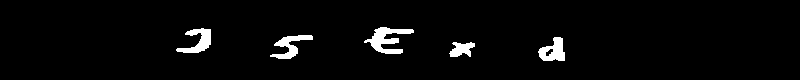

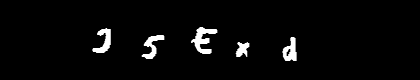

tensor([[[[0.6407]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


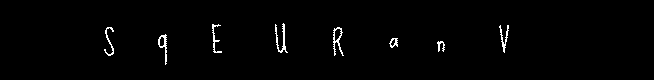

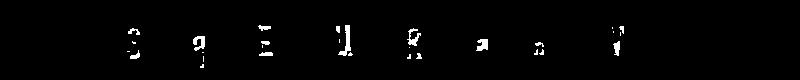

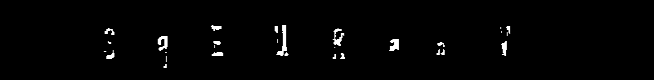

In [79]:
imported_netG = Generator().to(device)
imported_netD = Discriminator().to(device)

imported_netG.load_state_dict(torch.load(NET_G_PATH, weights_only=True))
imported_netD.load_state_dict(torch.load(NET_D_PATH, weights_only=True))

for _ in range(100):
  random_captcha = generate_random_captcha()
  width = random_captcha.size[0]
  generator_output = imported_netG(torch.stack([transform(random_captcha)]).to(device))
  verdict = imported_netD(generator_output)
  print(verdict)
  if verdict > 0.6:
    generator_output = generator_output[0].cpu().detach()
    display(random_captcha)
    display_image(generator_output)
    display_image_ori_width(generator_output, width)